# 데이터 및 라이브러리

In [54]:
!pip install prophet

  Using cached LunarCalendar-0.0.9-py2.py3-none-any.whl (18 kB)
  Using cached holidays-0.19-py3-none-any.whl (208 kB)


In [1]:
import pandas as pd
from datetime import datetime
import warnings
warnings.simplefilter("ignore", UserWarning)
import numpy as np
from prophet import Prophet

# 지도 시각화
import folium as g
from folium import Marker, Icon
import pandas as pd
import csv, time
import matplotlib.pyplot as plt

# 파이썬 시각화 패키지 불러오기
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


# 사용자 운영체제 확인
import platform
platform.system()

# 운영체제별 한글 폰트 설정
if platform.system() == 'Darwin': # Mac 환경 폰트 설정
    plt.rc('font', family='AppleGothic')
elif platform.system() == 'Windows': # Windows 환경 폰트 설정
    plt.rc('font', family='Malgun Gothic')

plt.rc('axes', unicode_minus=False) # 마이너스 폰트 설정


# 글씨 선명하게 출력하는 설정
%config InlineBackend.figure_format = 'retina'

In [2]:
KP2020 = pd.read_csv("data/치안/KP2020.csv", encoding = 'cp949')
KP2021 = pd.read_csv("data/치안/KP2021.csv", encoding = 'cp949')
NPA2020 = pd.read_csv('data/치안/NPA2020.csv', encoding = 'cp949')
codeBook = pd.read_excel('data/치안/codeBook_v3.xlsx')
대전광역시 = pd.read_csv('data/치안/대전광역시.csv', encoding = 'cp949')
세종시 = pd.read_csv('data/치안/세종시.csv', encoding = 'cp949')
충청남도 = pd.read_csv("data/치안/충청남도.csv", encoding = 'cp949')
휴일여부2020 = pd.read_csv("data/치안/휴일여부_2020.csv", encoding = 'cp949')
휴일여부2021 = pd.read_csv("data/치안/휴일여부_2021.csv", encoding = 'cp949')
휴일여부2022 = pd.read_csv("data/치안/휴일여부_2022.csv", encoding = 'cp949')
휴일여부2023 = pd.read_csv("data/치안/휴일여부_2023.csv", encoding = 'cp949')

In [61]:
휴일여부 = 휴일여부2020.append(휴일여부2021).append(휴일여부2022).append(휴일여부2023)
휴일여부 = 휴일여부.reset_index().drop('index', axis = 1)

C:\Users\jemin\AppData\Local\Temp\ipykernel_14920\1279692860.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  휴일여부 = 휴일여부2020.append(휴일여부2021).append(휴일여부2022).append(휴일여부2023)
C:\Users\jemin\AppData\Local\Temp\ipykernel_14920\1279692860.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  휴일여부 = 휴일여부2020.append(휴일여부2021).append(휴일여부2022).append(휴일여부2023)


In [428]:
NPA2020

,RECV_CPLT_DT,RECV_CPLT_TM,NPA_CL,EVT_STAT_CD,EVT_CL_CD,RPTER_SEX,HPPN_OLD_ADDR,HPPN_X,HPPN_Y,SME_EVT_YN
0,20200101,7,13,10,501,2,대전광역시 중구 목동(행정:목동) 360,127.409270,36.333010,Y
1,20200101,132,13,10,501,1,대전광역시 중구 대흥동(대흥동) 499-1,127.421295,36.325575,NaN
2,20200101,39,13,10,501,1,NaN,127.404663,36.341685,NaN
3,20200101,110,13,10,601,3,NaN,0.000000,0.000000,NaN
4,20200101,342,13,10,601,1,NaN,127.404663,36.341685,NaN
...,...,...,...,...,...,...,...,...,...,...
1178239,20201122,3505,19,10,501,1,,NaN,NaN,
1178240,20201122,5213,13,10,601,,,127.404663,36.341685,
1178241,20201122,4627,19,10,601,1,,NaN,NaN,Y
1178242,20201122,5246,19,5,301,1,충청남도 보령시 신흑동(행정:대천5동),126.516040,36.305619,


# 데이터 전처리

* 휴일여부

In [62]:
#누적 휴일 변수 만들어주기
holiday_count = [0] * 휴일여부.shape[0]
holiday = 휴일여부['휴일여부']

n = 1

for i in range(휴일여부.shape[0]):
    if holiday[i] == 'Y':
        holiday_count[i] = n
        n += 1
    else:
        n = 1

휴일여부['누적휴일'] = holiday_count

In [63]:
휴일여부

,Date,휴일여부,누적휴일
0,2020-01-01,Y,1
1,2020-01-02,N,0
2,2020-01-03,N,0
3,2020-01-04,Y,1
4,2020-01-05,Y,2
...,...,...,...
1122,2023-01-27,N,0
1123,2023-01-28,Y,1
1124,2023-01-29,Y,2
1125,2023-01-30,N,0


* 교통사고 건만 뽑기

In [49]:
# NPA_CL 컬럼
NPA_CL = codeBook[codeBook.컬럼명.str.contains('NPA_CL')]
NPA_CL = NPA_CL[['코드명','코드값']].reset_index().drop(['index'], axis = 1).rename(columns = {'코드값':'NPA_CL', '코드명':'경찰청 구분'})

# EVT_CL_CD 컬럼
EVT_CL_CD = codeBook[codeBook.컬럼명.str.contains('EVT_CL_CD')]
EVT_CL_CD = EVT_CL_CD[['코드명','코드값']].reset_index().drop(['index'], axis = 1).rename(columns = {'코드값':'EVT_CL_CD', '코드명':'사건종결코드'})

# EVT_STAT_CD 컬럼]
EVT_STAT_CD = codeBook[codeBook.컬럼명.str.contains('EVT_STAT_CD')]
EVT_STAT_CD = EVT_STAT_CD[['코드명','코드값']].reset_index().drop(['index'], axis = 1).rename(columns = {'코드값':'EVT_STAT_CD', '코드명':'사건상태코드'})

# # RPTER_SEX 컬럼
# RPTER_SEX = codeBook[codeBook.컬럼명.str.contains('RPTER_SEX')]
# RPTER_SEX = RPTER_SEX[['코드명','코드값']].reset_index().drop(['index'], axis = 1).rename(columns = {'코드값':'RPTER_SEX', '코드명':'신고 성별'})

# # NPA2020 - RPTER_SEX 괄호, 공백 행이 있음 -> 잠시 대기 나중에 다시

In [50]:
# NPA2020, KP2020, KP2021 와 각각 합치기
NPA2020 = NPA2020.merge(NPA_CL).merge(EVT_CL_CD).merge(EVT_CL_CD).merge(EVT_STAT_CD)
KP2020 = KP2020.merge(NPA_CL).merge(EVT_CL_CD).merge(EVT_CL_CD).merge(EVT_STAT_CD)
KP2021 = KP2021.merge(NPA_CL).merge(EVT_CL_CD).merge(EVT_CL_CD).merge(EVT_STAT_CD)

In [51]:
KP2020 = KP2020[KP2020['사건종결코드'].str.contains('교통사고') | KP2020['사건종결코드'].str.contains('음주운전') | KP2020['사건종결코드'].str.contains('교통불편') | KP2020['사건종결코드'].str.contains('교통위반')].reset_index().drop(['index'], axis = 1)
KP2021 = KP2021[KP2021['사건종결코드'].str.contains('교통사고') | KP2021['사건종결코드'].str.contains('음주운전') | KP2021['사건종결코드'].str.contains('교통불편') | KP2021['사건종결코드'].str.contains('교통위반')].reset_index().drop(['index'], axis = 1)
NPA2020 = NPA2020[NPA2020['사건종결코드'].str.contains('교통사고') | NPA2020['사건종결코드'].str.contains('음주운전') | NPA2020['사건종결코드'].str.contains('교통불편') | NPA2020['사건종결코드'].str.contains('교통위반')].reset_index().drop(['index'], axis = 1)

* NPA

In [52]:
# 컬럼 2개 합치는 함수
def combine_2rd_columns(col_1, col_2):
    result = str(col_1)
    if not pd.isna(col_2):
        result += " " + str(col_2)
    return result

In [53]:
# NPA 시간데이터에 0추가 (ex: 342 -> 000342)
NPA2020['RECV_CPLT_TM'] = NPA2020['RECV_CPLT_TM'].apply(lambda x:str(x).zfill(6))

# 년월일 시간 합친 컬럼 추가
NPA2020.insert(0, 'RECV_CPLT_DM', 0)
NPA2020['RECV_CPLT_DM'] = NPA2020.apply(lambda x: combine_2rd_columns(x['RECV_CPLT_DT'], x['RECV_CPLT_TM']), axis = 1)
NPA2020['RECV_CPLT_DM'] = pd.to_datetime(NPA2020['RECV_CPLT_DM'])

# 년 월 일 시간 컬럼 분리
NPA2020['year'] = NPA2020['RECV_CPLT_DM'].dt.year
NPA2020['month'] = NPA2020['RECV_CPLT_DM'].dt.month
NPA2020['day'] = NPA2020['RECV_CPLT_DM'].dt.day
NPA2020['time'] = NPA2020['RECV_CPLT_DM'].dt.time

# 컬럼 순서 수정
NPA2020 = NPA2020[['RECV_CPLT_DM', 'RECV_CPLT_DT', 'RECV_CPLT_TM', 'year', 'month', 'day', 'time', 'NPA_CL', 'EVT_STAT_CD',
       'EVT_CL_CD', 'RPTER_SEX', 'HPPN_OLD_ADDR', 'HPPN_X', 'HPPN_Y',
       'SME_EVT_YN', '경찰청 구분', '사건상태코드', '사건종결코드']]

NPA2020 = NPA2020.drop(['RECV_CPLT_DT', 'RECV_CPLT_TM'], axis = 1)


# OLD가 공백인데 X,Y 좌표값이 있는경우가 있음
# 하지만 그 좌표값들의 정보는 알수없음 따라서 OLD공백일때 일단 제외 시킬 것. (추후 사고발생 빈도 시각화할때는 사용할수 있을지도?)
# NPA2020 = NPA2020[NPA2020.HPPN_OLD_ADDR != " "]

# OLD가 NULL이면서 좌표도 NULL인경우 삭제

# OLD가 NULL이지만 좌표값 있는경우 NULL값 0으로 대체, -> 추후 시각화할때 빈도수 봐줘야하기 때문에 좌표값은 살림
NPA2020.HPPN_OLD_ADDR = NPA2020.HPPN_OLD_ADDR.fillna(0)

# 좌표값 0인경우 삭제
# X,Y좌표가 같음에도 사고발생지점이 다른경우존재 따라서 HPPN_ODL_ADDR이 NaN인 경우 제외.
# X, Y좌표 Nan값 제외 -> 지도시각화시 Nan값은 분석에 영향을 줌
NPA2020 = NPA2020[NPA2020.HPPN_X != 0]


# SME_EVT_YN Nan값 공백으로 대체
NPA2020.SME_EVT_YN = NPA2020.SME_EVT_YN.fillna(" ")
NPA2020 = NPA2020.dropna()



In [55]:
NPA2020['weekday'] = NPA2020.RECV_CPLT_DM.dt.weekday
NPA2020['weekday'].value_counts()

4    21439
5    21358
3    19778
0    19501
2    19341
1    19200
6    16832
Name: weekday, dtype: int64

* KP

In [506]:
#str datetime 변환
KP2020['RECV_CPLT_DM'] = KP2020['RECV_CPLT_DM'].apply(lambda _ : datetime.strptime(_,'%y/%m/%d %H:%M:%S.000000000'))
KP2021['RECV_CPLT_DM'] = KP2021['RECV_CPLT_DM'].apply(lambda _ : datetime.strptime(_,'%y/%m/%d %H:%M:%S.000000000'))
# 2020 변환
KP2020['year'] = KP2020['RECV_CPLT_DM'].dt.year
KP2020['month'] = KP2020['RECV_CPLT_DM'].dt.month
KP2020['day'] = KP2020['RECV_CPLT_DM'].dt.day
KP2020['time'] = KP2020['RECV_CPLT_DM'].dt.time
# 2021 변환
KP2021['year'] = KP2021['RECV_CPLT_DM'].dt.year
KP2021['month'] = KP2021['RECV_CPLT_DM'].dt.month
KP2021['day'] = KP2021['RECV_CPLT_DM'].dt.day
KP2021['time'] = KP2021['RECV_CPLT_DM'].dt.time

# 컬럼 순서 변경
KP2020=KP2020[['RECV_DEPT_NM', 'RECV_CPLT_DM', 'NPA_CL', 'year',
       'month', 'day', 'time', 'EVT_STAT_CD', 'EVT_CL_CD',
       'RPTER_SEX', 'HPPN_PNU_ADDR', 'HPPN_X', 'HPPN_Y', 'SME_EVT_YN', '경찰청 구분', '사건상태코드', '사건종결코드']]

KP2021=KP2021[['RECV_DEPT_NM', 'RECV_CPLT_DM', 'NPA_CL', 'year',
       'month', 'day', 'time', 'EVT_STAT_CD', 'EVT_CL_CD',
       'RPTER_SEX', 'HPPN_PNU_ADDR', 'HPPN_X', 'HPPN_Y', 'SME_EVT_YN', '경찰청 구분', '사건상태코드', '사건종결코드']]

KP2020=KP2020.drop('RECV_DEPT_NM', axis = 1)
KP2021=KP2021.drop('RECV_DEPT_NM', axis = 1)

KP2020 = KP2020.rename(columns = {"HPPN_PNU_ADDR":"HPPN_OLD_ADDR"})
KP2021 = KP2021.rename(columns = {"HPPN_PNU_ADDR":"HPPN_OLD_ADDR"})

KP2020.HPPN_OLD_ADDR = KP2020.HPPN_OLD_ADDR.fillna(0)
KP2020 = KP2020[KP2020.HPPN_X != 0]
KP2020.SME_EVT_YN = KP2020.SME_EVT_YN.fillna(" ")
KP2020 = KP2020.dropna()

KP2021.HPPN_OLD_ADDR = KP2021.HPPN_OLD_ADDR.fillna(0)
KP2021 = KP2021[KP2021.HPPN_X != 0]
KP2021.SME_EVT_YN = KP2021.SME_EVT_YN.fillna(" ")
KP2021 = KP2021.dropna()

* 합치기

In [507]:
# NPA, KP 데이터셋 합치기
치안 = NPA2020.append(KP2020).append(KP2021)
치안=치안.reset_index().drop('index', axis= 1)

# 휴일여부 데이터 합치기
치안['Date'] = 치안['RECV_CPLT_DM'].dt.date
치안['Date']=치안['Date'].astype('str')
치안=치안.reset_index().drop('index' , axis = 1)
치안=치안.merge(휴일여부, on = 'Date', how = 'left')

C:\Users\jemin\AppData\Local\Temp\ipykernel_112228\4052267841.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  치안 = NPA2020.append(KP2020).append(KP2021)
C:\Users\jemin\AppData\Local\Temp\ipykernel_112228\4052267841.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  치안 = NPA2020.append(KP2020).append(KP2021)


## 여기부터 실행(여기부터가 전처리 완료된 CSV임)

In [2]:
치안 = pd.read_csv("data/치안/치안.csv")

C:\Users\jemin\AppData\Local\Temp\ipykernel_11548\2085551631.py:1: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  치안 = pd.read_csv("data/치안/치안.csv")


In [3]:
치안.head()

,Unnamed: 0,RECV_CPLT_DM,year,month,day,time,NPA_CL,EVT_STAT_CD,EVT_CL_CD,RPTER_SEX,HPPN_OLD_ADDR,HPPN_X,HPPN_Y,SME_EVT_YN,경찰청 구분,사건상태코드,사건종결코드,Date,휴일여부,누적휴일
0,0,2020-01-01 00:32:40,2020,1,1,00:32:40,13,10,402,1,대전광역시 서구 탄방동(탄방동) 1447-1,127.386346,36.346856,,대전청,종결요청,교통불편,2020-01-01,Y,1
1,1,2020-01-01 20:30:28,2020,1,1,20:30:28,13,10,402,1,대전광역시 서구 갈마동(행정:갈마2동) 345-10,127.373106,36.347504,,대전청,종결요청,교통불편,2020-01-01,Y,1
2,2,2020-01-01 21:40:45,2020,1,1,21:40:45,13,10,402,1,대전광역시 서구 내동(행정:내동) 152-18,127.368317,36.335125,,대전청,종결요청,교통불편,2020-01-01,Y,1
3,3,2020-01-01 15:09:52,2020,1,1,15:09:52,13,10,402,1,대전광역시 동구 삼정동(행정:판암1동) 388-14,127.480283,36.330858,,대전청,종결요청,교통불편,2020-01-01,Y,1
4,4,2020-01-01 15:17:09,2020,1,1,15:17:09,13,10,402,1,대전광역시 중구 대흥동(행정:대흥동) 121-5,127.429738,36.325342,Y,대전청,종결요청,교통불편,2020-01-01,Y,1


* 대전

In [13]:
# 대전만 추출
대전 = 치안[치안.HPPN_OLD_ADDR.str.contains("대전")]
대전 = 대전.reset_index().drop('index', axis = 1)

# 대전 날씨정보 합치기
대전광역시=대전광역시.rename(columns = {'일시':'Date'})
대전=대전.merge(대전광역시)
대전=대전.drop('Unnamed: 0', axis = 1)

In [14]:
대전

,RECV_CPLT_DM,year,month,day,time,NPA_CL,EVT_STAT_CD,EVT_CL_CD,RPTER_SEX,HPPN_OLD_ADDR,...,평균기온(°C),최저기온(°C),최고기온(°C),일강수량(mm),평균 풍속(m/s),평균 상대습도(%),일 최심신적설(cm),일 최심적설(cm),평균 전운량(1/10),안개 계속시간(hr)
0,2020-01-01 00:32:40,2020,1,1,00:32:40,13,10,402,1,대전광역시 서구 탄방동(탄방동) 1447-1,...,-0.6,-7.7,5.1,0.0,0.9,65.8,NaN,NaN,6.5,NaN
1,2020-01-01 20:30:28,2020,1,1,20:30:28,13,10,402,1,대전광역시 서구 갈마동(행정:갈마2동) 345-10,...,-0.6,-7.7,5.1,0.0,0.9,65.8,NaN,NaN,6.5,NaN
2,2020-01-01 21:40:45,2020,1,1,21:40:45,13,10,402,1,대전광역시 서구 내동(행정:내동) 152-18,...,-0.6,-7.7,5.1,0.0,0.9,65.8,NaN,NaN,6.5,NaN
3,2020-01-01 15:09:52,2020,1,1,15:09:52,13,10,402,1,대전광역시 동구 삼정동(행정:판암1동) 388-14,...,-0.6,-7.7,5.1,0.0,0.9,65.8,NaN,NaN,6.5,NaN
4,2020-01-01 15:17:09,2020,1,1,15:17:09,13,10,402,1,대전광역시 중구 대흥동(행정:대흥동) 121-5,...,-0.6,-7.7,5.1,0.0,0.9,65.8,NaN,NaN,6.5,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151259,2023-01-18 10:52:38,2023,1,18,10:52:38,13,10,406,3.0,대전광역시 유성구 구암동 (온천1동 ) 370-1,...,-0.8,-3.6,4.0,0.0,1.3,61.6,0.1,0.1,4.8,NaN
151260,2023-01-18 20:52:24,2023,1,18,20:52:24,13,10,406,1.0,대전광역시 유성구 학하동 (학하동 ) 387-4,...,-0.8,-3.6,4.0,0.0,1.3,61.6,0.1,0.1,4.8,NaN
151261,2023-01-18 21:10:12,2023,1,18,21:10:12,13,10,406,3.0,대전광역시 유성구 지족동 (노은1동 ) 907-9,...,-0.8,-3.6,4.0,0.0,1.3,61.6,0.1,0.1,4.8,NaN
151262,2023-01-18 21:37:04,2023,1,18,21:37:04,13,10,406,2.0,대전광역시 유성구 하기동 (행정:노은2동 ) 575,...,-0.8,-3.6,4.0,0.0,1.3,61.6,0.1,0.1,4.8,NaN


In [519]:
대전['사건종결코드'].value_counts()

교통사고    98706
교통불편    22983
음주운전    18826
교통위반    10749
Name: 사건종결코드, dtype: int64

* 시간별 사고 집계
* 요일별 사고 집계
* 월별 사고 집계
* 계절별 사고 집계
* 누적휴일별 사고 집계
* 날씨 사고 집계

* 요일별 사고 집계

In [18]:
대전['RECV_CPLT_DM'] = pd.to_datetime(대전['RECV_CPLT_DM'])
대전['weekday'] = 대전['RECV_CPLT_DM'].dt.weekday
대전['count'] = 1

대전_2020 = 대전[대전.year == 2020]

In [19]:
대전_2020_시각화 = 대전_2020.groupby('weekday')[['count']].sum().reset_index()

In [48]:
대전_2020.weekday.value_counts()

4    7940
5    7820
3    7782
2    7435
0    7377
1    7353
6    5977
Name: weekday, dtype: int64

In [45]:
대전_2020_시각화

,weekday,count
0,0,7377
1,1,7353
2,2,7435
3,3,7782
4,4,7940
5,5,7820
6,6,5977


<AxesSubplot:xlabel='weekday'>

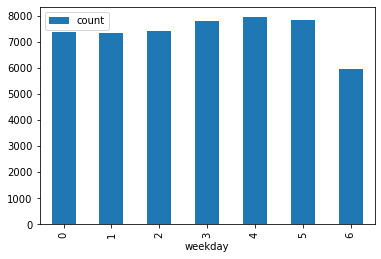

In [21]:
대전_2020_시각화.plot.bar(x='weekday', y='count')#, 대전_2020_시각화.count)

* 시간별 사고집계

In [28]:
# 시간만 뽑는 함수
def time(x):
    return x[:2]

대전['시간'] = 대전['time'].map(time)

# 시간 카테고리 나누는 함수
# 0~6시 새벽, 7~12 아침, 1~6시 점심, 7~11시 저녁
def time_cat(x):
    if 0 <= int(x) <= 6:
        return '새벽'
    elif 7 <= int(x) <= 12:
        return '아침'
    elif 13 <= int(x) <= 18:
        return '낮'
    elif 19 <= int(x) <= 23:
        return '저녁'
    
대전['시간_cat'] = 대전['시간'].map(time_cat)

In [35]:
대전.시간_cat.value_counts()

# 사고의 심각돌르 봐줘도 될듯 -> 새벽 사고는 보통 대형사고야 알지

낮     54950
아침    38357
저녁    37289
새벽    20668
Name: 시간_cat, dtype: int64

In [41]:
대전_평일 = 대전[대전.휴일여부 == 'N']

대전_평일['시간'] = 대전_평일['time'].map(time)
대전_평일['시간_cat'] = 대전_평일['시간'].map(time_cat)

C:\Users\jemin\AppData\Local\Temp\ipykernel_7292\704141584.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  대전_평일['시간'] = 대전_평일['time'].map(time)
C:\Users\jemin\AppData\Local\Temp\ipykernel_7292\704141584.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  대전_평일['시간_cat'] = 대전_평일['시간'].map(time_cat)


In [42]:
대전_평일.시간_cat.value_counts()

# 평일 vs 주말 구분해서 봐주기

낮     38374
아침    28373
저녁    26246
새벽    12153
Name: 시간_cat, dtype: int64

In [43]:
대전_휴일 = 대전[대전.휴일여부 == 'Y']

대전_휴일['시간'] = 대전_휴일['time'].map(time)
대전_휴일['시간_cat'] = 대전_휴일['시간'].map(time_cat)

C:\Users\jemin\AppData\Local\Temp\ipykernel_7292\2161374770.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  대전_휴일['시간'] = 대전_휴일['time'].map(time)
C:\Users\jemin\AppData\Local\Temp\ipykernel_7292\2161374770.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  대전_휴일['시간_cat'] = 대전_휴일['시간'].map(time_cat)


In [44]:
대전_휴일.시간_cat.value_counts()

# 평일 vs 주말 구분해서 봐주기

낮     16576
저녁    11043
아침     9984
새벽     8515
Name: 시간_cat, dtype: int64

# 사고별 EDA

In [76]:
치안_뽑 = 치안[치안['HPPN_OLD_ADDR'].str.contains('대전광역시') | 치안['HPPN_OLD_ADDR'].str.contains('세종시') | 치안['HPPN_OLD_ADDR'].str.contains('충청남도')| 치안['HPPN_OLD_ADDR'].str.contains('충남')]
치안_뽑 = 치안_뽑.rename(columns = {'사건종결코드':'사건종별코드'})

In [77]:
치안_뽑.사건종별코드.value_counts()

교통사고    237839
음주운전     63754
교통불편     54330
교통위반     31020
Name: 사건종별코드, dtype: int64

* 요일별 사고집계

C:\Users\jemin\AppData\Local\Temp\ipykernel_11548\1665570880.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  음주운전['count'] = 1
C:\Users\jemin\AppData\Local\Temp\ipykernel_11548\1665570880.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  음주운전['RECV_CPLT_DM'] = pd.to_datetime(음주운전['RECV_CPLT_DM'])
C:\Users\jemin\AppData\Local\Temp\ipykernel_11548\1665570880.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value i

[Text(0, 0, '월'),
 Text(1, 0, '화'),
 Text(2, 0, '수'),
 Text(3, 0, '목'),
 Text(4, 0, '금'),
 Text(5, 0, '토'),
 Text(6, 0, '일')]

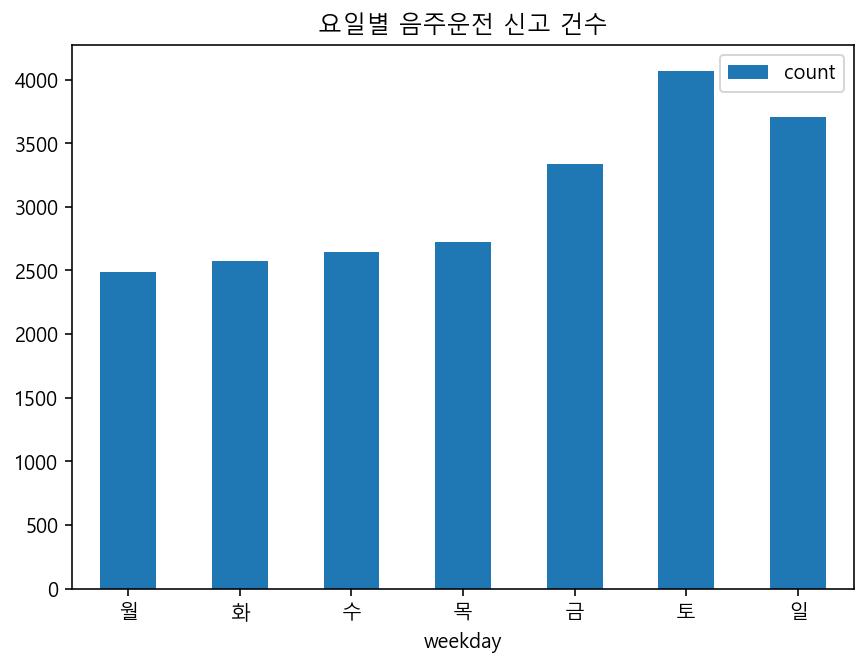

In [6]:
음주운전 = 치안_뽑[치안_뽑['사건종별코드'].str.contains('음주운전')]

음주운전['count'] = 1


# 음주운전
음주운전['RECV_CPLT_DM'] = pd.to_datetime(음주운전['RECV_CPLT_DM'])
음주운전['weekday'] = 음주운전['RECV_CPLT_DM'].dt.weekday

음주운전_2021 = 음주운전[음주운전.year == 2021]
# 요일별 사고 집계
음주운전_2021_시각화 = 음주운전_2021.groupby('weekday')[['count']].sum().reset_index()


fig, ax = plt.subplots(figsize = (7,5), ncols = 1)

음주운전_2021_시각화.plot.bar(x = 'weekday', y = 'count', ax = ax)
ax.set_title('요일별 음주운전 신고 건수')
ax.set_xticklabels(['월','화','수','목','금','토','일'], rotation = 0)


* 월별 사고집계

<AxesSubplot:title={'center':'월별 음주운전 사고량'}, xlabel='month'>

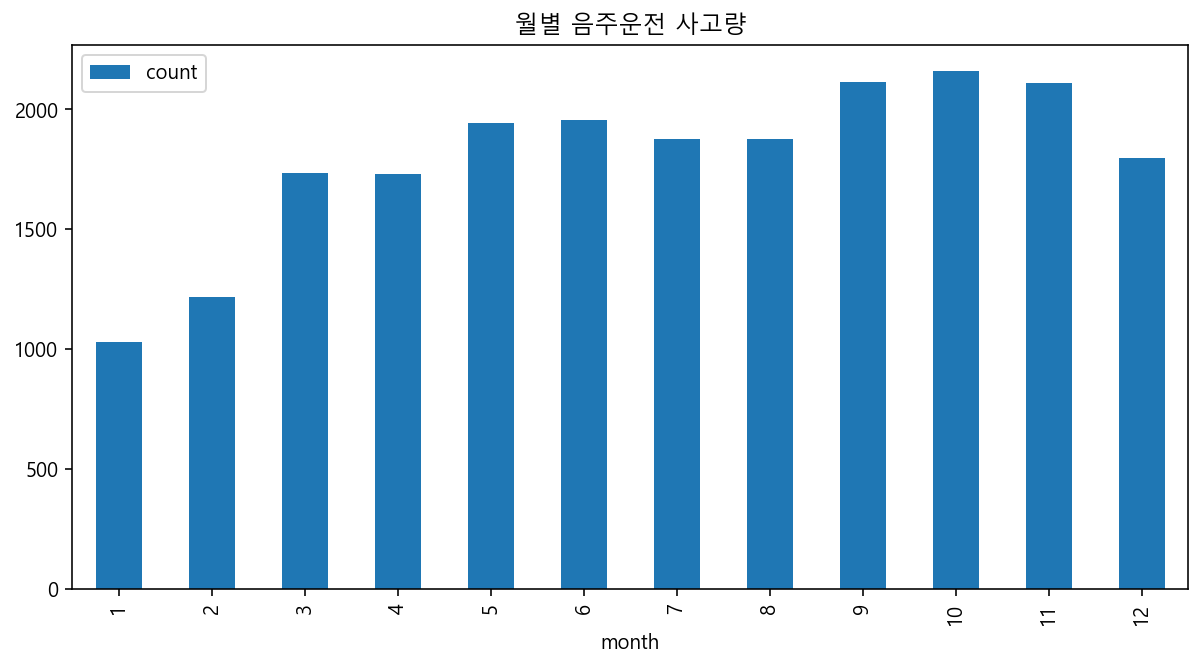

In [7]:
# 2021년 월별 사고수

fig, ax = plt.subplots(figsize = (10,5), ncols=1)

#음주운전
음주운전_2021_month = 음주운전_2021.groupby('month')['count'].sum().reset_index().set_index('month')

ax.set_title('월별 음주운전 사고량')
음주운전_2021_month.plot.bar(ax = ax)
# ax.set_xticklabels(['월','화','수','목','금','토','일'], rotation = 0)

* 시간별 사고집계

C:\Users\jemin\AppData\Local\Temp\ipykernel_11548\3367349209.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  음주운전['시간'] = 음주운전['time'].map(time)
C:\Users\jemin\AppData\Local\Temp\ipykernel_11548\3367349209.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  음주운전['시간_cat'] = 음주운전['시간'].map(time_cat)


Text(0.5, 1.0, '시간별 음주운전 신고 건수')

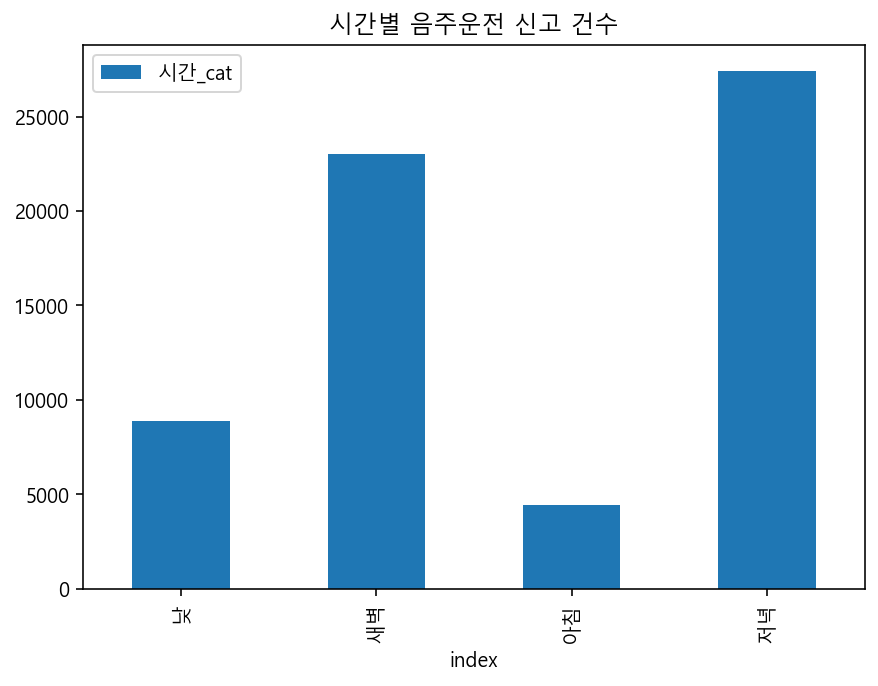

In [9]:
# 시간만 뽑는 함수
def time(x):
    return x[:2]

# 시간 카테고리 나누는 함수
# 0~6시 새벽, 7~12 아침, 1~6시 점심, 7~11시 저녁
def time_cat(x):
    if 0 <= int(x) <= 6:
        return '새벽'
    elif 7 <= int(x) <= 12:
        return '아침'
    elif 13 <= int(x) <= 18:
        return '낮'
    elif 19 <= int(x) <= 23:
        return '저녁'
      
# 교통사고['시간'] = 교통사고['time'].map(time)
# 교통사고['시간_cat'] = 교통사고['시간'].map(time_cat)

음주운전['시간'] = 음주운전['time'].map(time)
음주운전['시간_cat'] = 음주운전['시간'].map(time_cat)

# 교통불편['시간'] = 교통불편['time'].map(time)
# 교통불편['시간_cat'] = 교통불편['시간'].map(time_cat)

# 교통위반['시간'] = 교통위반['time'].map(time)
# 교통위반['시간_cat'] = 교통위반['시간'].map(time_cat)

fig, ax = plt.subplots(figsize = (7,5), ncols=1)

음주운전.시간_cat.value_counts().reset_index().sort_values('index').plot.bar(x = 'index', y = '시간_cat', ax=ax)
ax.set_title('시간별 음주운전 신고 건수')


* 기온별 음주운전

In [ ]:
# def tmp(day):
#     if day <= -2 or day >= 30:
#         return '매우 낮거나 높음'
#     elif day > -2 and day <= 12.8:
#         return '낮음'
#     elif day > 12.8 and day < 30:
#         return '높음'

* 계절별 음주운전

In [10]:
음주운전.year.value_counts()

2022    24486
2021    21539
2020    16702
2023     1027
Name: year, dtype: int64

In [421]:
#3·4·5월을 봄, 6·7·8월을 여름, 9·10·11월을 가을, 12·1·2월을 겨울
음주운전_2021['계절'] =''

def cat(month):
    if month == 1 or month == 2 or month == 12:
        return '겨울'
    elif month == 3 or month == 4 or month == 5:
        return '봄'
    elif month == 6 or month == 7 or month == 8:
        return '여름'
    elif month == 9 or month == 10 or month == 11:
        return '가을'

음주운전_2021['계절'] = 음주운전_2021['month'].map(cat)

C:\Users\jemin\AppData\Local\Temp\ipykernel_14920\2479577692.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  음주운전_2021['계절'] =''
C:\Users\jemin\AppData\Local\Temp\ipykernel_14920\2479577692.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  음주운전_2021['계절'] = 음주운전_2021['month'].map(cat)


Text(0, 0.5, '신고 건수')

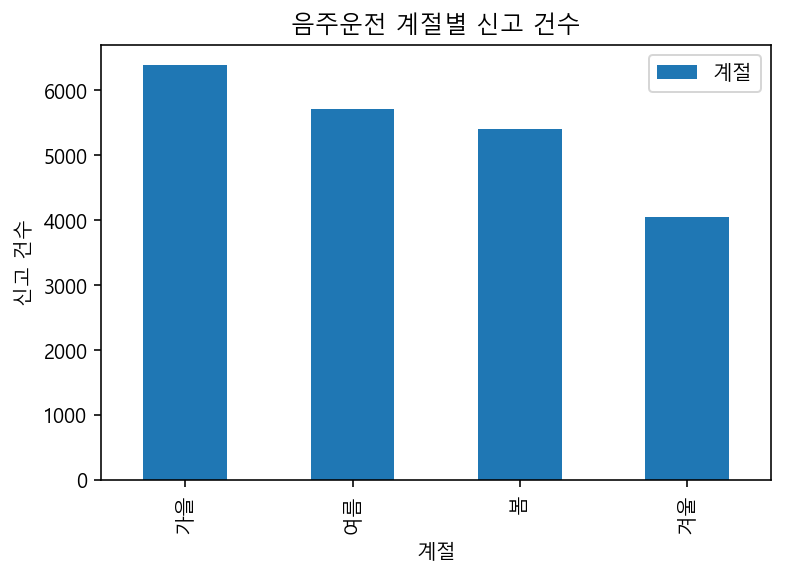

In [422]:
음주운전_계절 = 음주운전_2021['계절'].value_counts()

음주운전_계절.reset_index().plot.bar(x='index' , y = '계절').set_title('음주운전 계절별 신고 건수')
plt.xlabel('계절')
plt.ylabel('신고 건수')

* 누적휴일별 음주운전

Text(0, 0.5, '신고 건수')

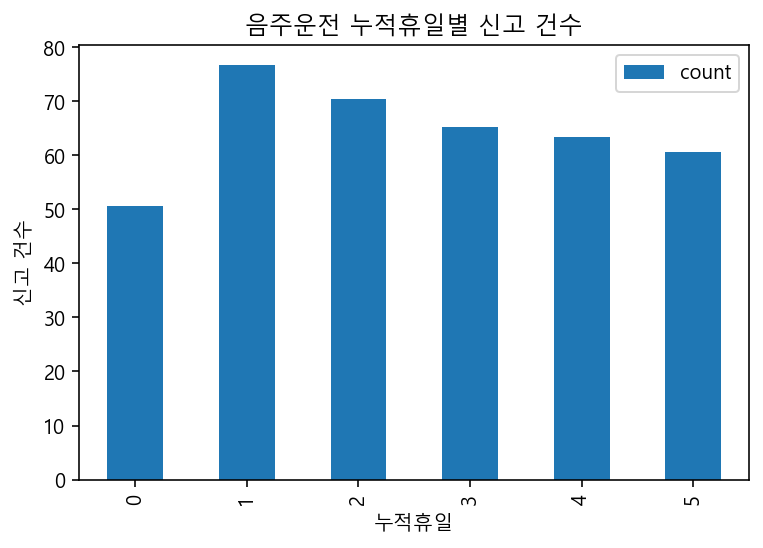

In [423]:
음주운전_누적휴일 = 음주운전.groupby('Date')[['count']].sum().reset_index()

누적휴일 = 음주운전_누적휴일.merge(휴일여부)
누적휴일_시각화 = 누적휴일.groupby('누적휴일').mean().reset_index()

누적휴일_시각화.plot.bar(x = '누적휴일', y = 'count').set_title('음주운전 누적휴일별 신고 건수')
plt.xlabel('누적휴일')
plt.ylabel('신고 건수')

* 음주운전 시계열 변환

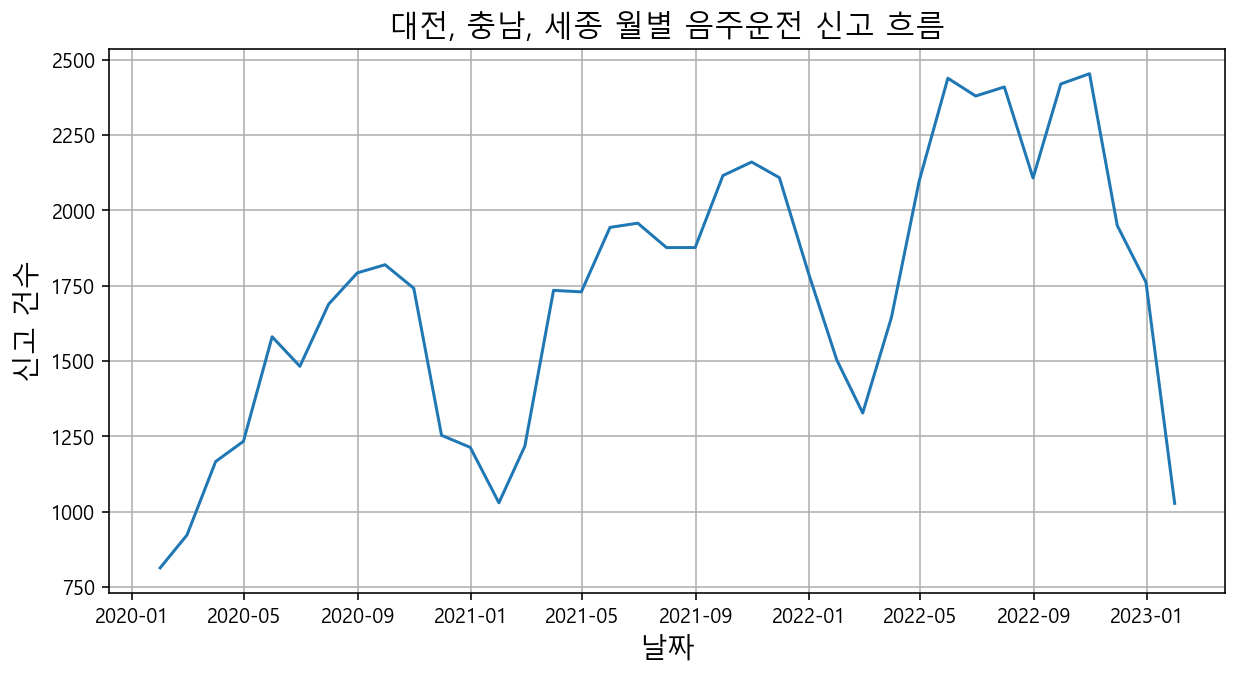

In [78]:
음주운전_group = 음주운전.groupby('Date')[['count']].sum().reset_index()
음주운전_group['Date'] = pd.to_datetime(음주운전_group['Date'])

# 월별 다운샘플링
test = 음주운전_group.set_index('Date').resample(rule='M').sum()
plt.figure(figsize = (10, 5))
plt.plot(test)
plt.title('대전, 충남, 세종 월별 음주운전 신고 흐름', fontsize = 15)
plt.xlabel('날짜', fontsize = 14)
plt.ylabel('신고 건수', fontsize = 14)
plt.grid(True)
plt.show()

# 모델링 - ARIMA

In [79]:
test.head()

,count
Date,
2020-01-31,813
2020-02-29,922
2020-03-31,1166
2020-04-30,1233
2020-05-31,1580


https://leedakyeong.tistory.com/entry/Python-%EB%82%A0%EC%94%A8-%EC%8B%9C%EA%B3%84%EC%97%B4-%EB%8D%B0%EC%9D%B4%ED%84%B0Kaggle%EB%A1%9C-ARIMA-%EC%A0%81%EC%9A%A9%ED%95%98%EA%B8%B0

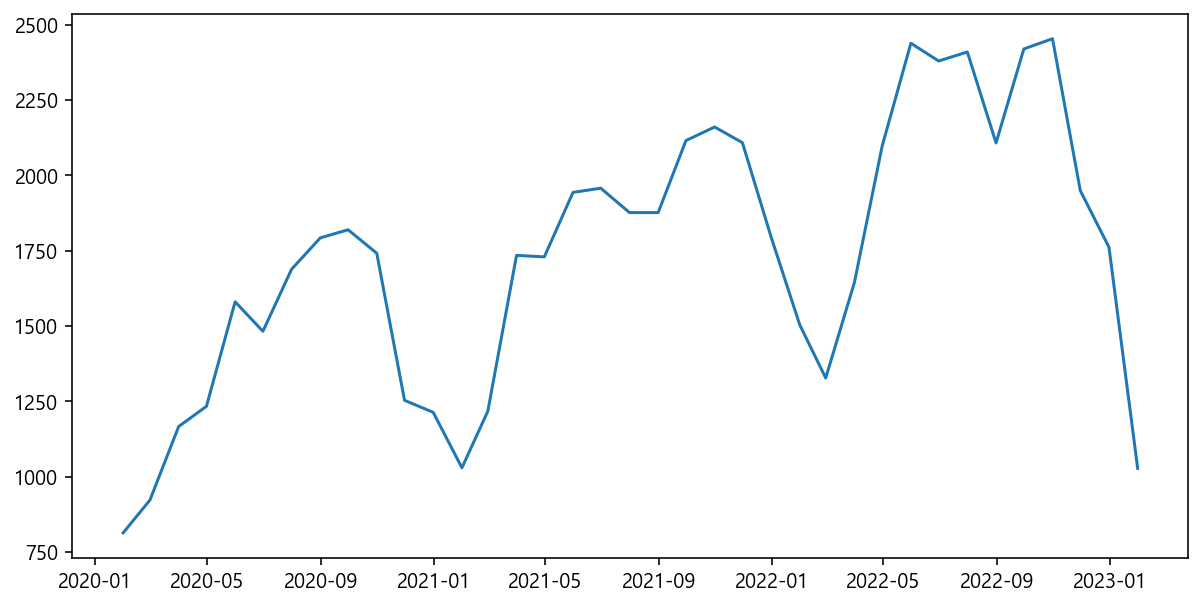

In [117]:
plt.figure(figsize = (10, 5))
plt.plot(test)

In [118]:
# timeSeries = 교통사고_group.loc[:, ["Date", "count"]]
# timeSeries = timeSeries.set_index('Date')
# ts = timeSeries.drop('Date', axis=1)
ts = test
# ts = timeSeries.drop("Date", axis = 1)

In [119]:
ts.head()

,count
Date,
2020-01-31,813
2020-02-29,922
2020-03-31,1166
2020-04-30,1233
2020-05-31,1580


<Figure size 432x288 with 0 Axes>

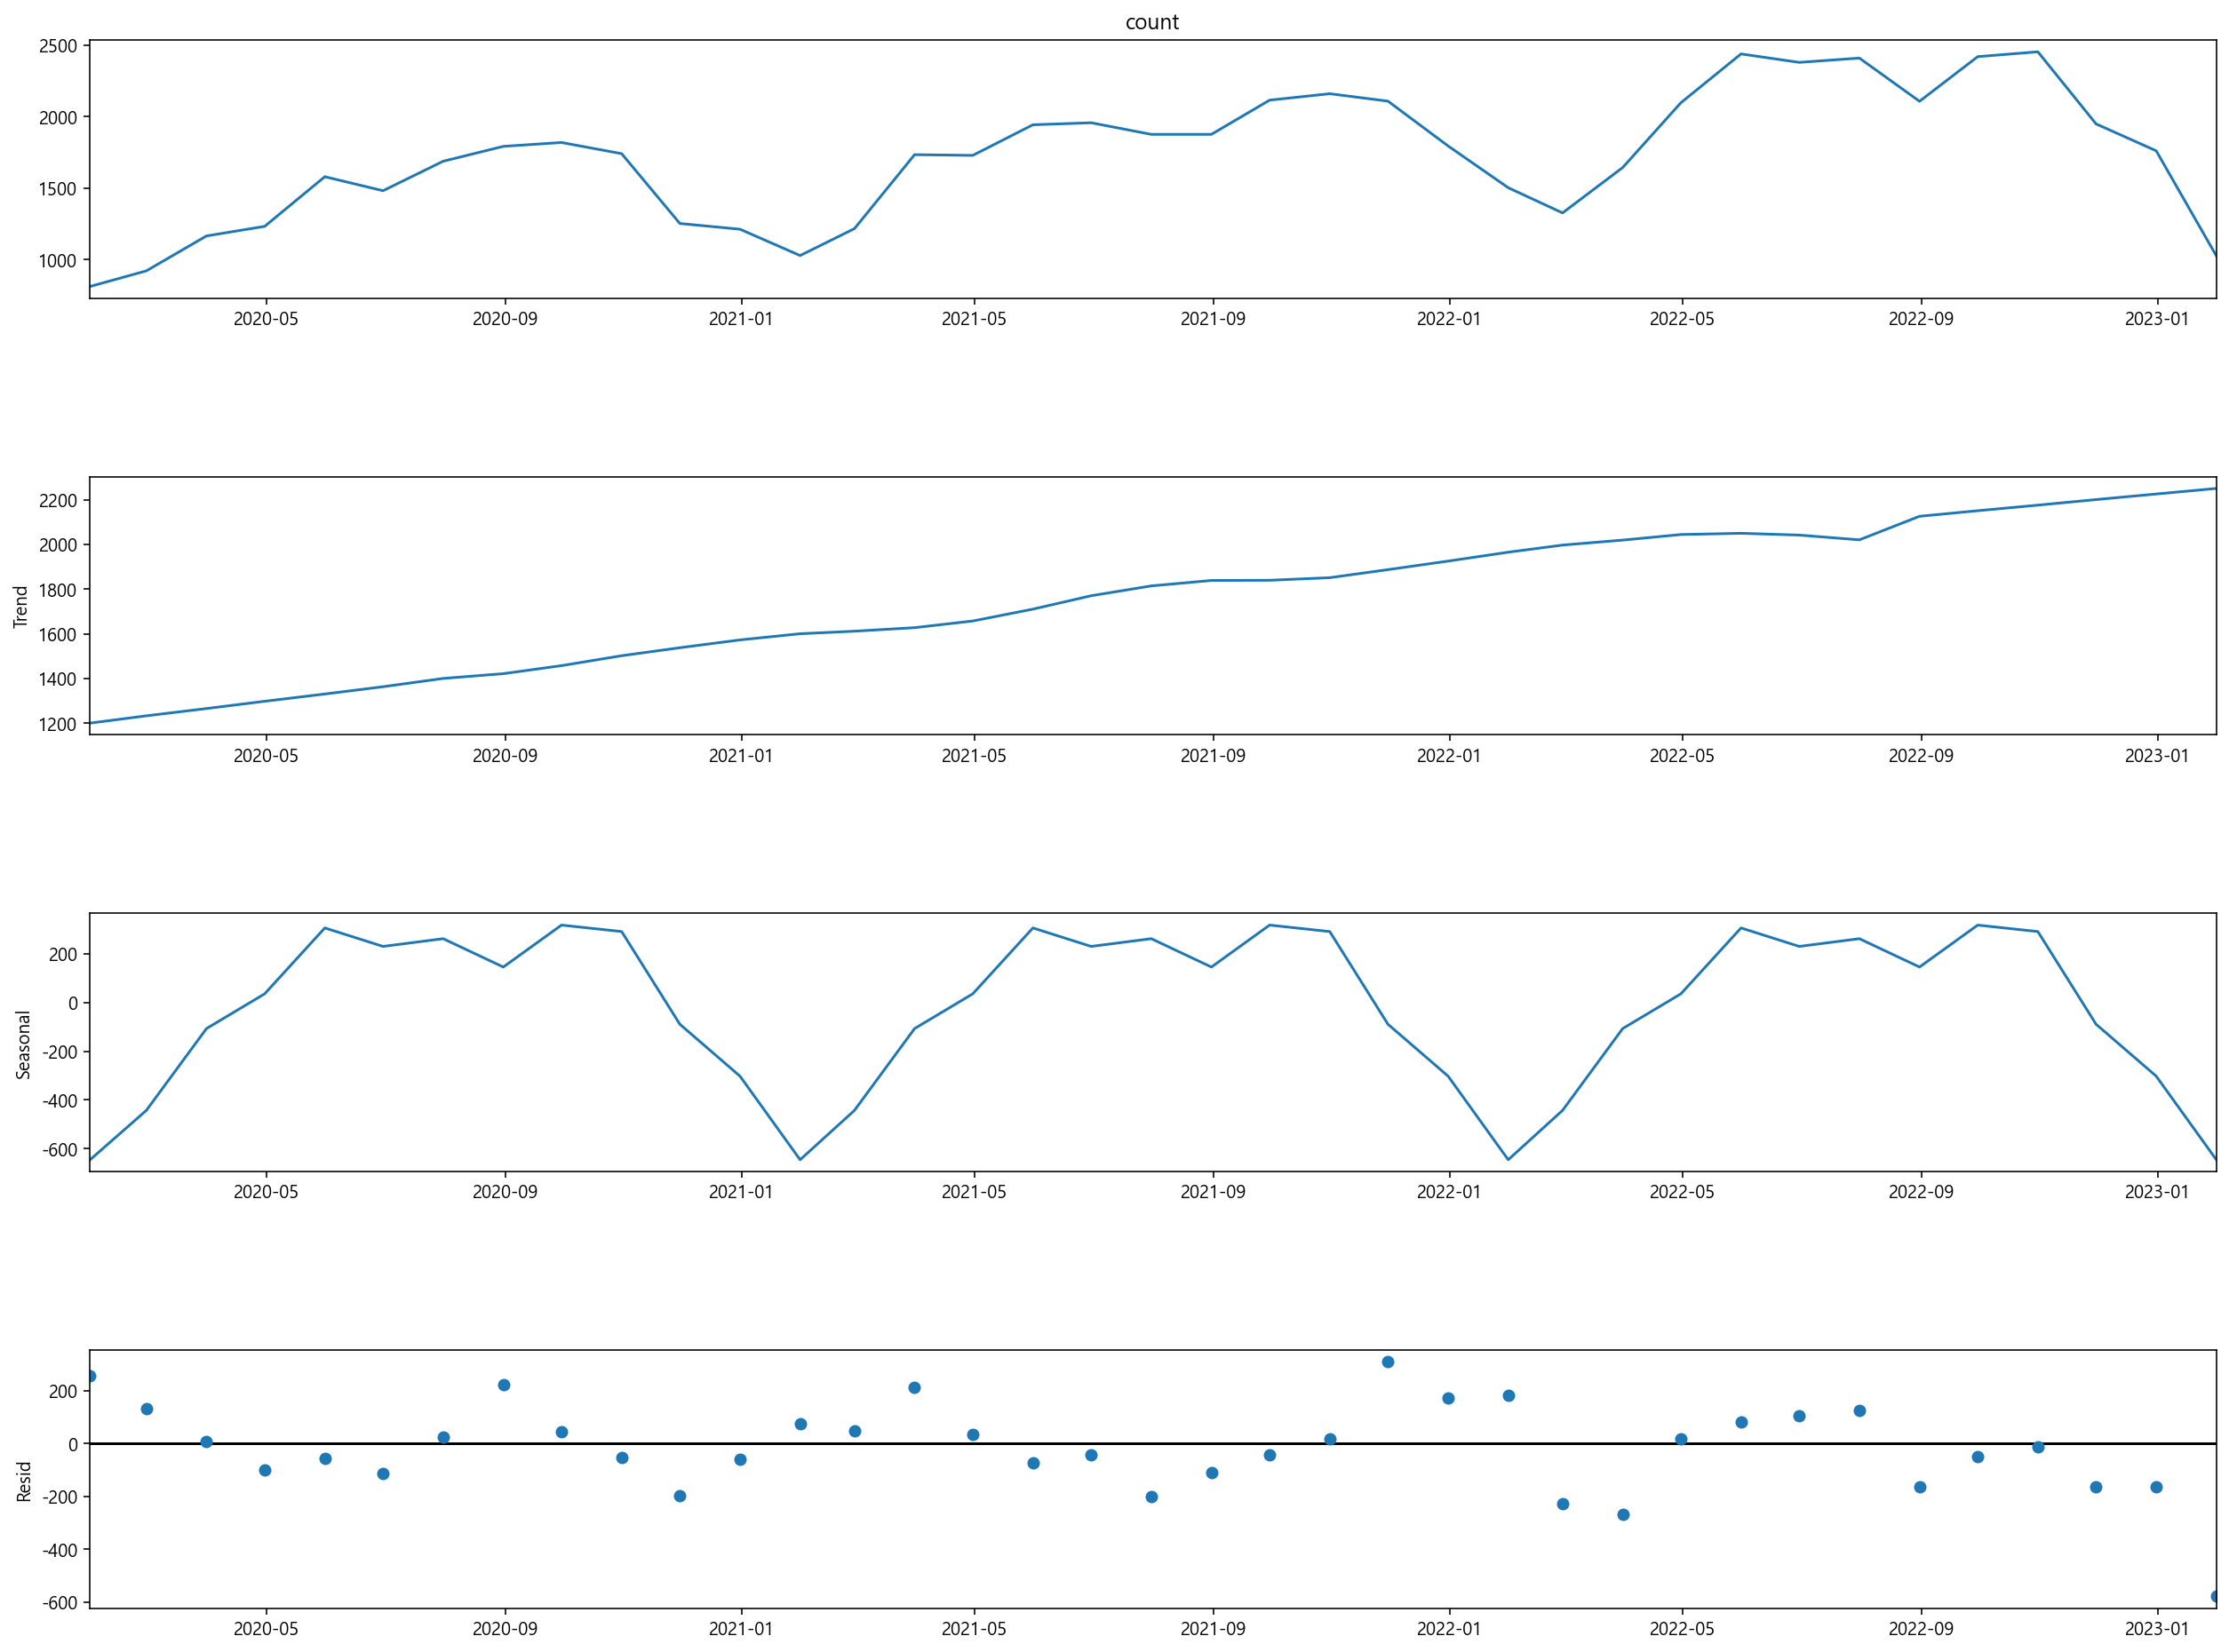

In [120]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(ts['count'], model='additive', extrapolate_trend=12)

fig = plt.figure()
fig = result.plot()
fig.set_size_inches(20, 15)

# 데이터에 패턴이 보이기 때문에 정상성 의심

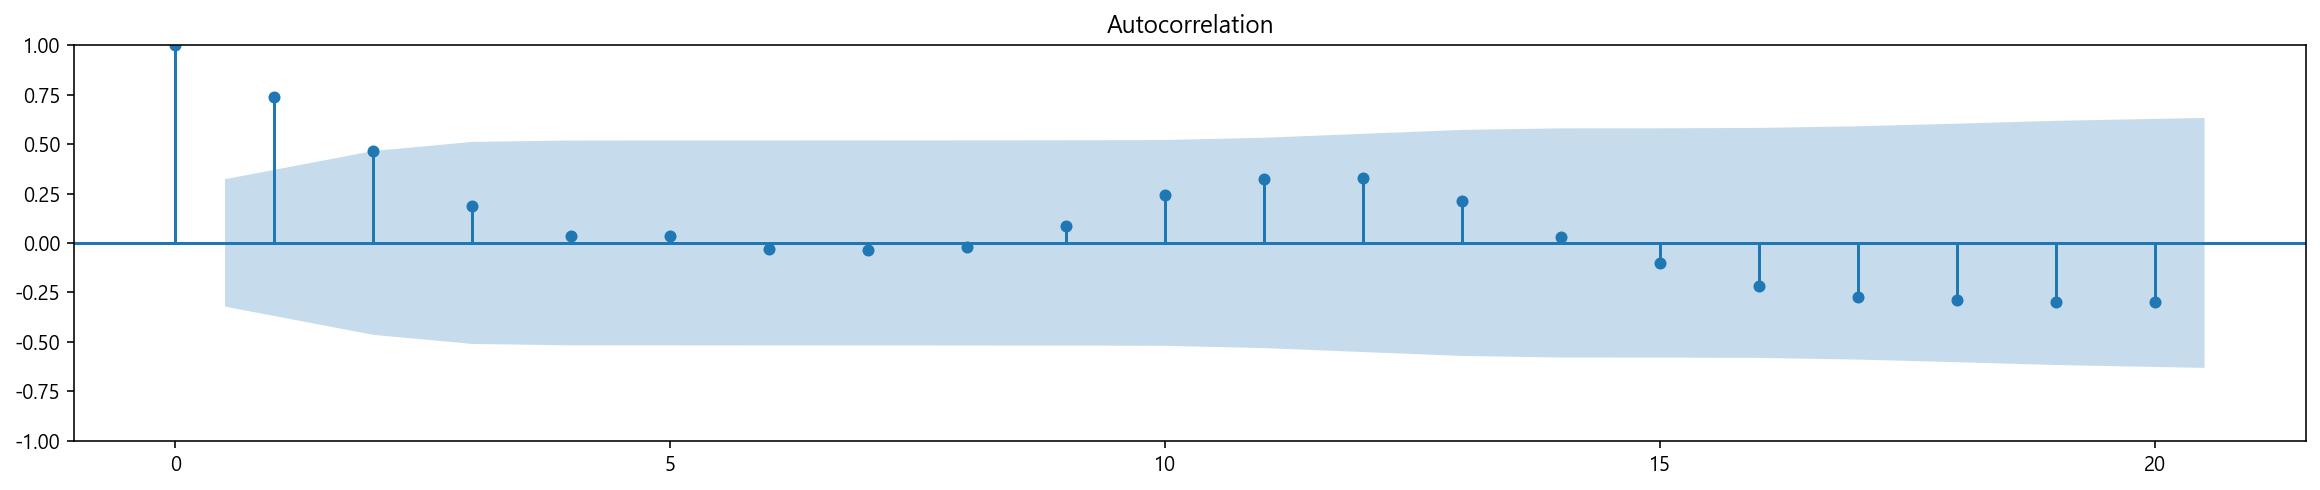

In [121]:
# 정상성을 판단하기 위한 ACF그래프

import statsmodels.api as sm

fig = plt.figure(figsize = (20, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts, lags = 20, ax = ax1)

In [122]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(ts)
print('ADF Statistic: ',result[0])
print('p-value: ', result[1])
print('Critical Values: ')
for k, v in result[4].items():
    print('\tt%s: %.3f' % (k, v))

# 귀무가설(H0): 자료에 단위근이 존재한다. 즉, 정상성을 만족하지 못한다.
# 대립가설(H1): 자료가 정상성을 만족한다.
# p-value가 0.05를 넘으므로, 귀무가설 기각 못함
# 따라서 해당 데이터는 정상성을 만족하지 못함

ADF Statistic:  -1.182272295797563
p-value:  0.6811748579170984
Critical Values: 
	t1%: -3.700
	t5%: -2.976
	t10%: -2.628


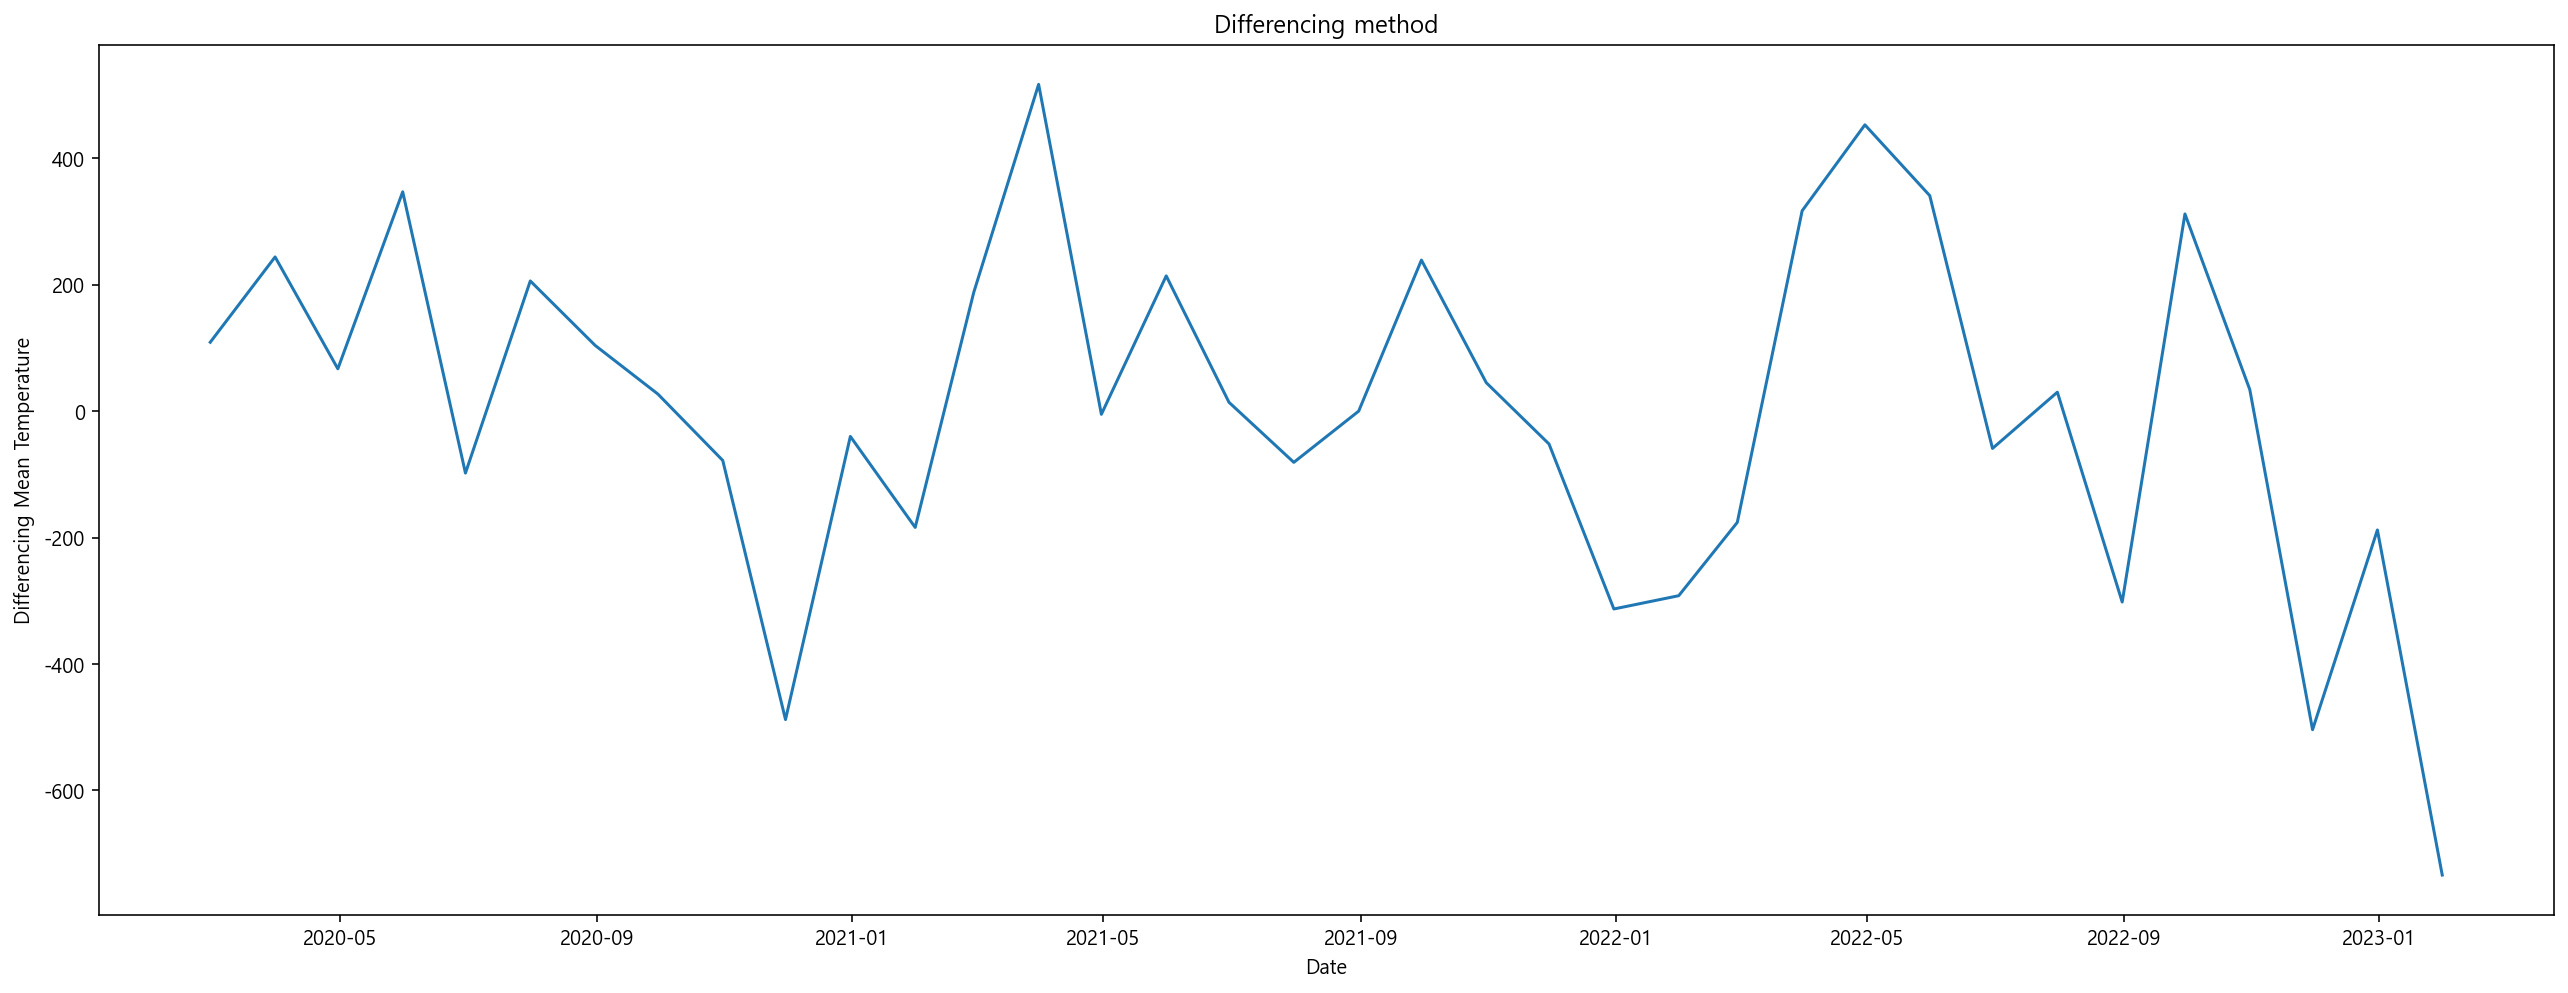

In [123]:
# 1차 차분
ts_diff = ts - ts.shift()
plt.figure(figsize = (22, 8))
plt.plot(ts_diff)
plt.title('Differencing method')
plt.xlabel('Date')
plt.ylabel('Differencing Mean Temperature')
plt.show()

# 1차 미분 결과 일정한 패턴이 확인되지 않고, 정상성을 만족함

In [124]:
# ADF 검정 결과 확인

result = adfuller(ts_diff[1:])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values: ')
for k, v in result[4].items():
    print('\t%s: %.3f' % (k, v))
    
# p-value가 0.05보다 작으므로 귀무가설 기각, 따라서 1차 차분한 데이터는 정상성 만족

ADF Statistic: -4.330657
p-value: 0.000393
Critical Values: 
	1%: -3.700
	5%: -2.976
	10%: -2.628


C:\Users\jemin\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


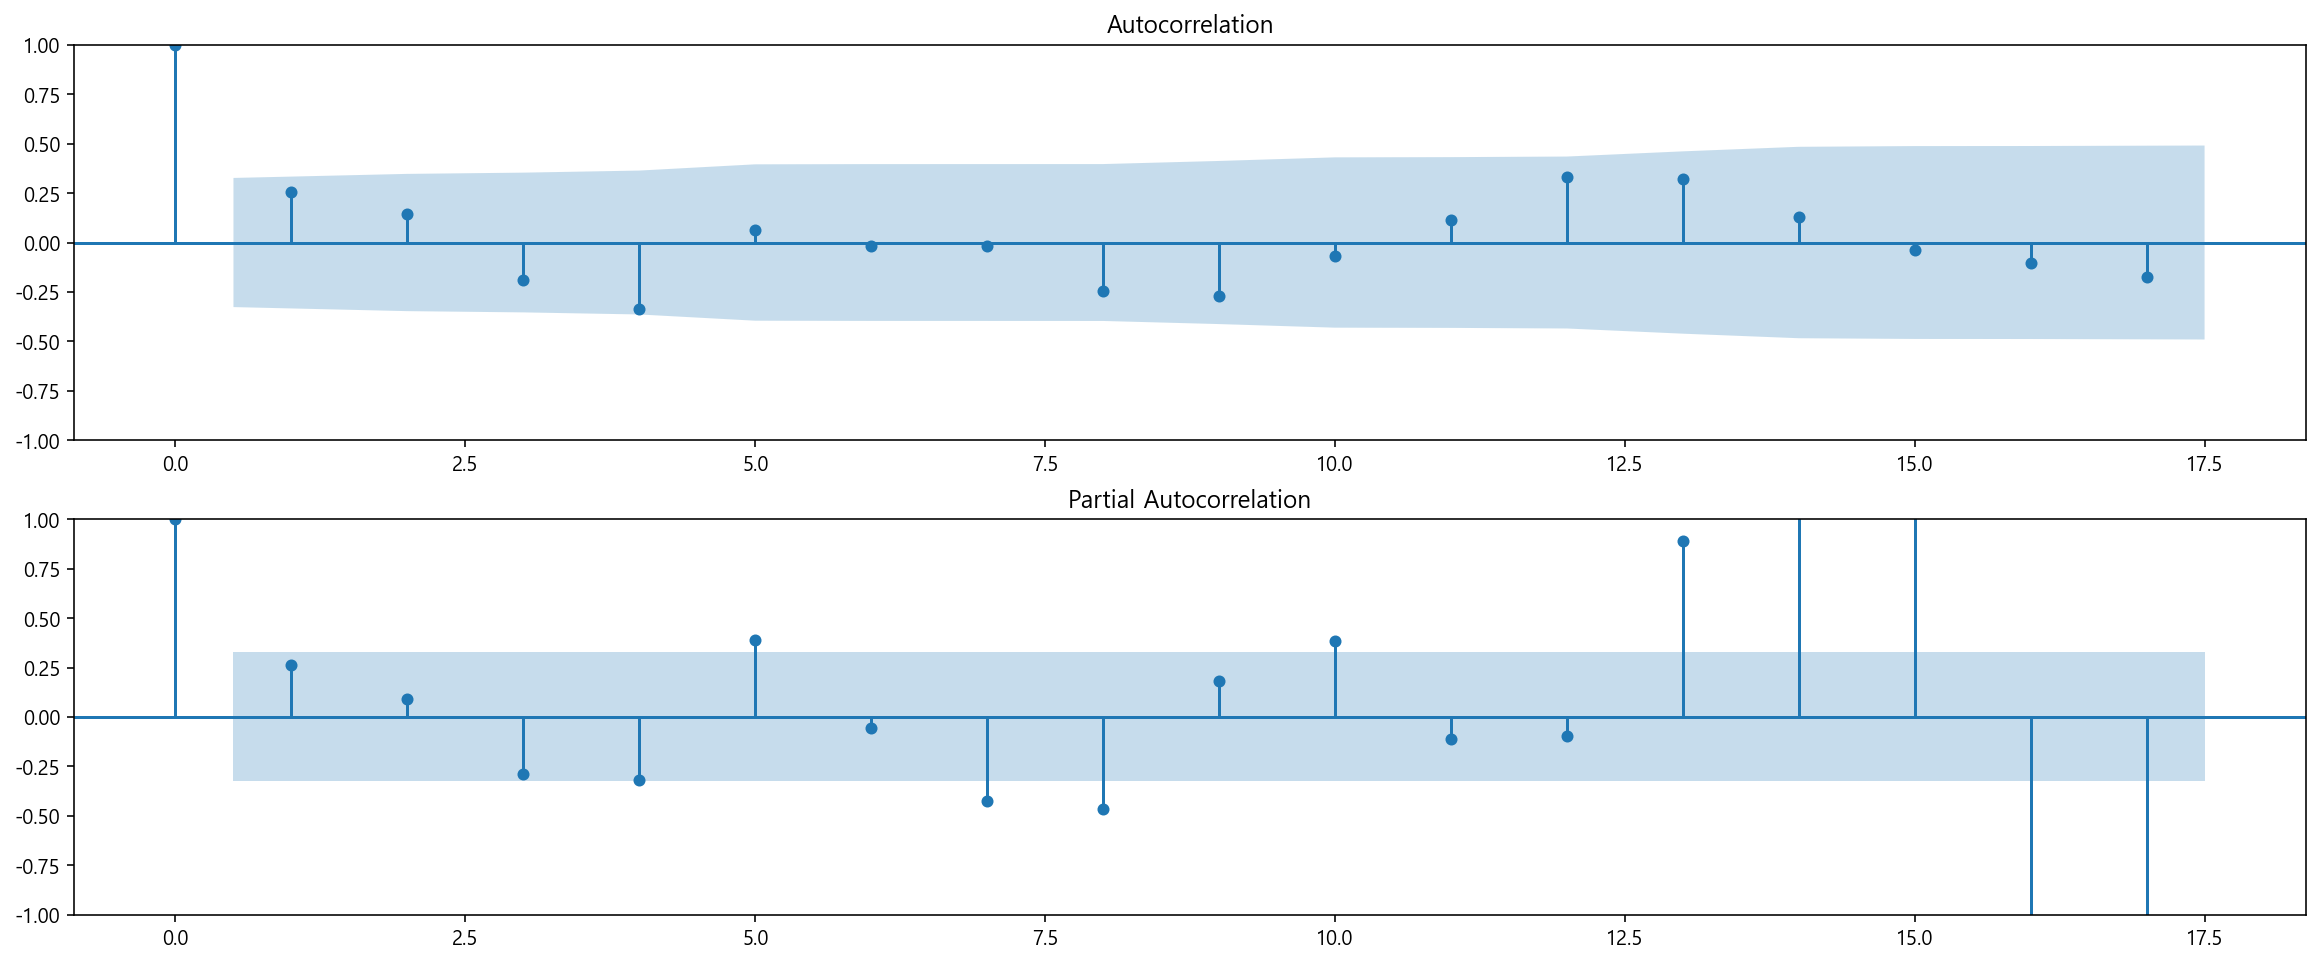

In [125]:
# 정상성을 만족하는 차분된 데이터로 ACF과 PACF를 그려 ARIMA 모형의 p와 q를 결정한다.

import statsmodels.api as sm

fig = plt.figure(figsize = (20, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts_diff[1:], lags = 17, ax = ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts_diff[1:], lags = 17
                                , ax = ax2)

In [126]:
# from statsmodels.tsa.arima_model import ARIMA
# from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
# import statsmodels.api as sm
# from pandas import datetime
# # import pmdarima as pm
# # from pmdarima.model_selection import train_test_split

# # fit model
# model = ARIMA(ts,order = (0, 1, 1))
# model_fit = model.fit(disp = 0)

# # predict
# start_index = datetime(2022, 5, 31)
# end_index = datetime(2023, 1, 18)
# forecast = model_fit.predict(start = start_index, end = end_index, typ = 'levels')

# # 시각화
# plt.figure(figsize = (22, 8))
# plt.plot(weather_bin.Date, weather_bin.MeanTemp, label = "original")
# plt.plot(forecast, label = 'predicted')
# plt.title('Time Series Forcast')
# plt.xlabel('Date')
# plt.ylabel('Mean Temperature')
# plt.legend()
# plt.show()

In [127]:
ts_diff1 = ts_diff.dropna()

In [128]:
from pmdarima.arima import auto_arima
model_arima = auto_arima(ts['count'], trace = True, error_action = 'ignore', start_p = 1, start_q = 1, max_p = 3, max_q = 3, suppress_warnings = True, stepwise = False, seasonal = False)
model_arima.fit(ts)

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=509.104, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=508.933, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=501.746, Time=0.19 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=502.809, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=508.040, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=509.906, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=503.447, Time=0.19 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=509.655, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=511.327, Time=0.08 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=509.185, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercep

ARIMA(order=(0, 1, 2), scoring_args={}, suppress_warnings=True)

In [129]:
from statsmodels.tsa.arima.model import ARIMA

p=0 # AR모형의 lag, p개 만큼 AR가 과거 데이터활용
q=2 # MA모형의 lag, q개 만큼 MA가 과거 데이터활용
d=1 # 차분횟수

# 학습
model = ARIMA(ts, order = (p,d,q))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  count   No. Observations:                   37
Model:                 ARIMA(0, 1, 2)   Log Likelihood                -246.873
Date:                Mon, 13 Feb 2023   AIC                            499.746
Time:                        18:05:40   BIC                            504.496
Sample:                    01-31-2020   HQIC                           501.404
                         - 01-31-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2021      0.145      1.395      0.163      -0.082       0.486
ma.L2          0.8750      0.210      4.158      0.000       0.463       1.287
sigma2      4.891e+04   9231.591      5.298      0.0

In [130]:
# predict
start_index = datetime(2022, 1, 31)
end_index = datetime(2022, 12, 31)
forecast = model_fit.predict(start = start_index, end = end_index, typ = 'levels')

In [131]:
ts_set = ts.reset_index()

In [132]:
train_arima = ts_set[:27]
test_arima = ts_set[27:36]
predict_arima = forecast[3:12]

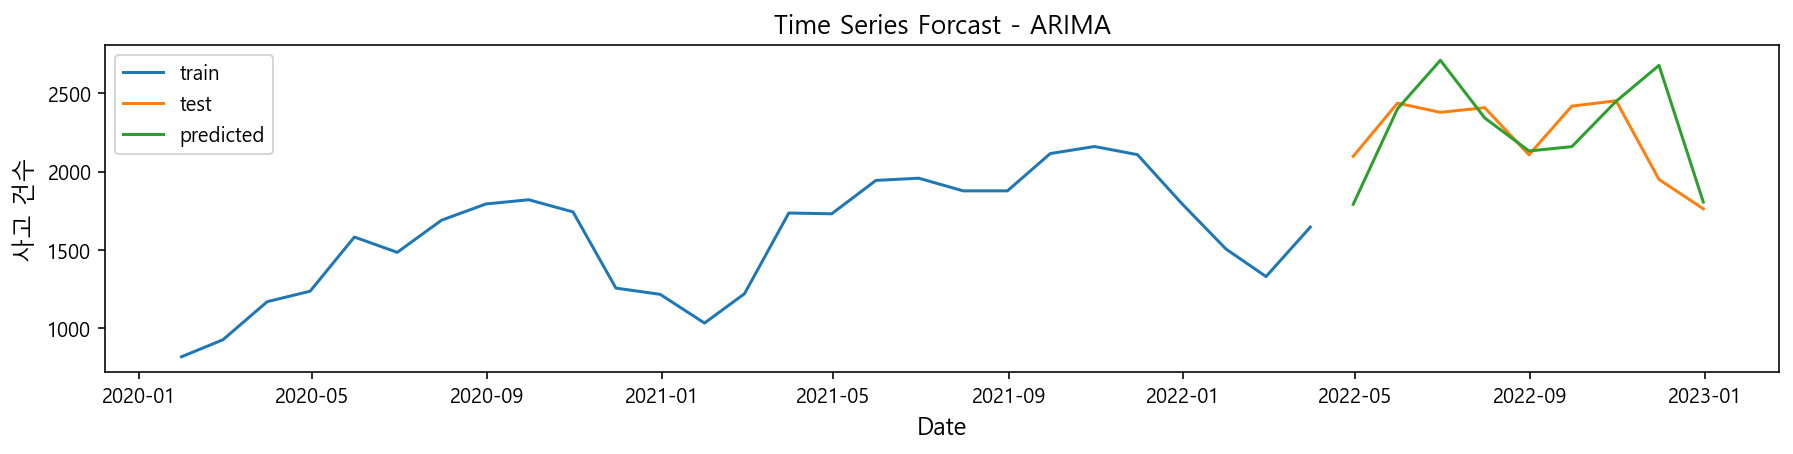

In [133]:
# 시각화
plt.figure(figsize = (15, 3))
plt.plot(train_arima.Date, train_arima['count'], label = "train")
plt.plot(test_arima.Date, test_arima['count'], label = "test")
plt.plot(predict_arima, label = 'predicted')
plt.title('Time Series Forcast - ARIMA', fontsize = 13)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('사고 건수', fontsize = 12)
plt.legend()
plt.show()

In [135]:
test1= ts.reset_index()

In [136]:
np.array(test1[test1.Date >= start_index]['count'])[:-1]

array([1503, 1327, 1644, 2097, 2438, 2379, 2409, 2107, 2419, 2453, 1949,
       1761], dtype=int64)

In [137]:
np.array(forecast)

array([1483.61690318, 1224.07173053, 1364.49821974, 1789.70787712,
       2401.6849182 , 2712.67076414, 2343.27413634, 2131.55562479,
       2159.30713791, 2449.95465333, 2680.12074374, 1804.15444588])

In [139]:
# 마지막 성능 확인
from sklearn import metrics

def scoring(y_true, y_pred):
    # r2 = round(metrics.r2_score(y_true, y_pred) * 100, 3)
    # corr = round(np.corrcoef(y_true, y_pred)[0, 1], 3)
    # mape = round(metrics.mean_absolute_percentage_error(y_true, y_pred) * 100, 3)
    # rmse = round(metrics.mean_squared_error(y_true, y_pred, squared = False), 3)
    mae = round(metrics.mean_absolute_error(y_true, y_pred), 3)
    
    df = pd.DataFrame({
    #     # 'R2':r2,
    #     # 'Corr':corr,
    #     # 'RMSE':rmse,
    #     # 'MAPE': mape,
        'MAE':mae}, index = ["ARIMA의 MAE"])
    return mae
    # print("ARIMA Model MAE : ", mae)

ARIMA_mae = scoring(np.array(test1[test1.Date >= start_index]['count'])[:-1], np.array(forecast))
ARIMA_mae

183.866

In [255]:
pd.DataFrame({
        'MAE':[round(ARIMA_mae, 2)]},
    index = ["ARIMA의 MAE"])

,MAE
ARIMA의 MAE,183.87


# 모델링 - 지수이동평균

In [170]:
test = 음주운전_group.set_index('Date').resample(rule='M').sum()

In [161]:
def make_ewm_arr(data_frame, span_num):
    arr_ewm = np.array([])
    arr_ewm = np.concatenate((arr_ewm, test['count'].ewm(span=span_num).mean().values))
    
    return arr_ewm

test = test.reset_index()


ewm_month = test.copy()

ewm_month.insert(2, 'amount_3ewm', make_ewm_arr(test, 3))
ewm_month.insert(3, 'amount_6ewm', make_ewm_arr(test, 6))

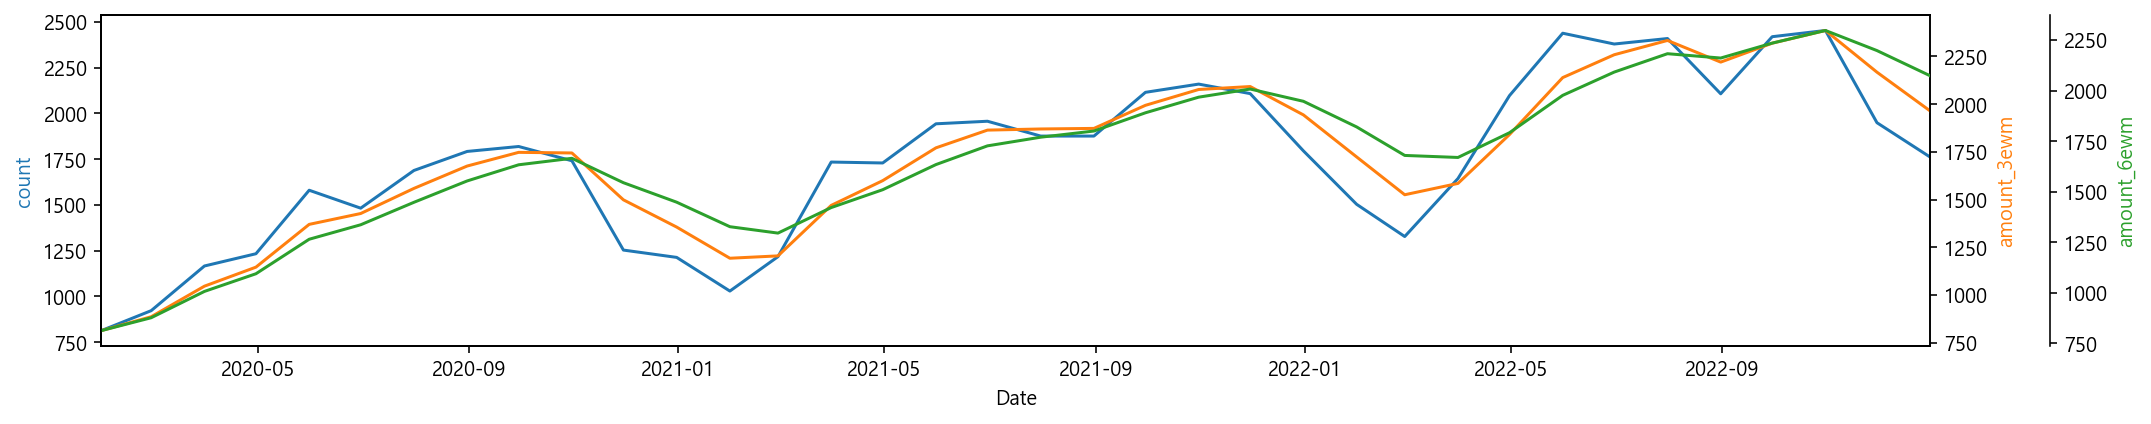

In [162]:
# 지수이동평균 결과 시각화

def plot_model_graph(data_frame, idx_col, y_cols):
    df_set = data_frame
    
    fig, ax1 = plt.subplots(figsize=(15, 3))
    ax1.set_xlabel("{}".format(idx_col))
    ax1.set_ylabel("{}".format(y_cols[0])).set_color(color='tab:blue')
    ax1.plot(df_set.Date, df_set[y_cols[0]].values, color='tab:blue')
    ax1.set_xlim(datetime(2020, 1, 31), datetime(2022, 12, 31))
    
    for i in range(1, len(y_cols)):
        ax2 = ax1.twinx()
        ax2.set_ylabel("{}".format(y_cols[i])).set_color(color='C{}'.format(i))
        ax2.plot(df_set.Date, df_set[y_cols[i]].values, color='C{}'.format(i))
        ax2.set_xlim(datetime(2020, 1, 31), datetime(2022, 12, 31))
        ax2.spines['right'].set_position(('outward', (60*(i-1))))

    fig.tight_layout()
    plt.show()
    
plot_model_graph(ewm_month, 'Date', ['count', 'amount_3ewm', 'amount_6ewm'])

In [163]:
# 예측 성능 지표
def mae(prediction, correct):
    prediction = np.array(prediction)
    correct = np.array(correct)
    
    difference = correct - prediction
    abs_val = abs(difference)
    
    score = abs_val.mean()
    
    return score

# 사고건수 예측
def make_ewm_arr(data_frame, span_num):
    arr_ewm = np.array([])
    arr_ewm = np.concatenate((arr_ewm, total['count'].ewm(span=span_num).mean().values))
    
    return arr_ewm

# 예측결과 시각화 함수
def plot_train_test_pred_graph(trainset, testset, pred):
    plt.figure(figsize=(15,3))
    plt.plot(train['Date'], train['count'], label='train')
    plt.plot(testset['Date'], testset['count'], label='test')
    plt.plot(predict['Date'] ,predict['count_3ewm'], label='prediction')
    plt.title("Time Series Forecast - EMA", fontsize = 13)
    plt.xlabel('Date', fontsize = 12)
    plt.ylabel('사고 건수', fontsize = 12)
    plt.legend()
    plt.show()

In [174]:
# 대전, 세종, 충남만 뽑기
# 치안_뽑 = 치안[치안['HPPN_OLD_ADDR'].str.contains('대전광역시') | 치안['HPPN_OLD_ADDR'].str.contains('세종시') | 치안['HPPN_OLD_ADDR'].str.contains('충청남도')| 치안['HPPN_OLD_ADDR'].str.contains('충남')]
# 치안_뽑 = 치안_뽑.rename(columns = {'사건종결코드':'사건종별코드'})

# # 일별 사고건수 카운팅을 위해 count변수 추가
# 치안_뽑['count'] = 1

# # 예측
total = test.copy()
# total = total[['Date', 'count']]
# total.Date = pd.to_datetime(total.Date)

total=total.resample(rule = 'M').sum()
total=total.reset_index()

# total = total.iloc[:36]

ewm_month = total.copy()

ewm_month.insert(2, 'count_3ewm', make_ewm_arr(total, 3))
ewm_month.insert(3, 'count_6ewm', make_ewm_arr(total, 6))

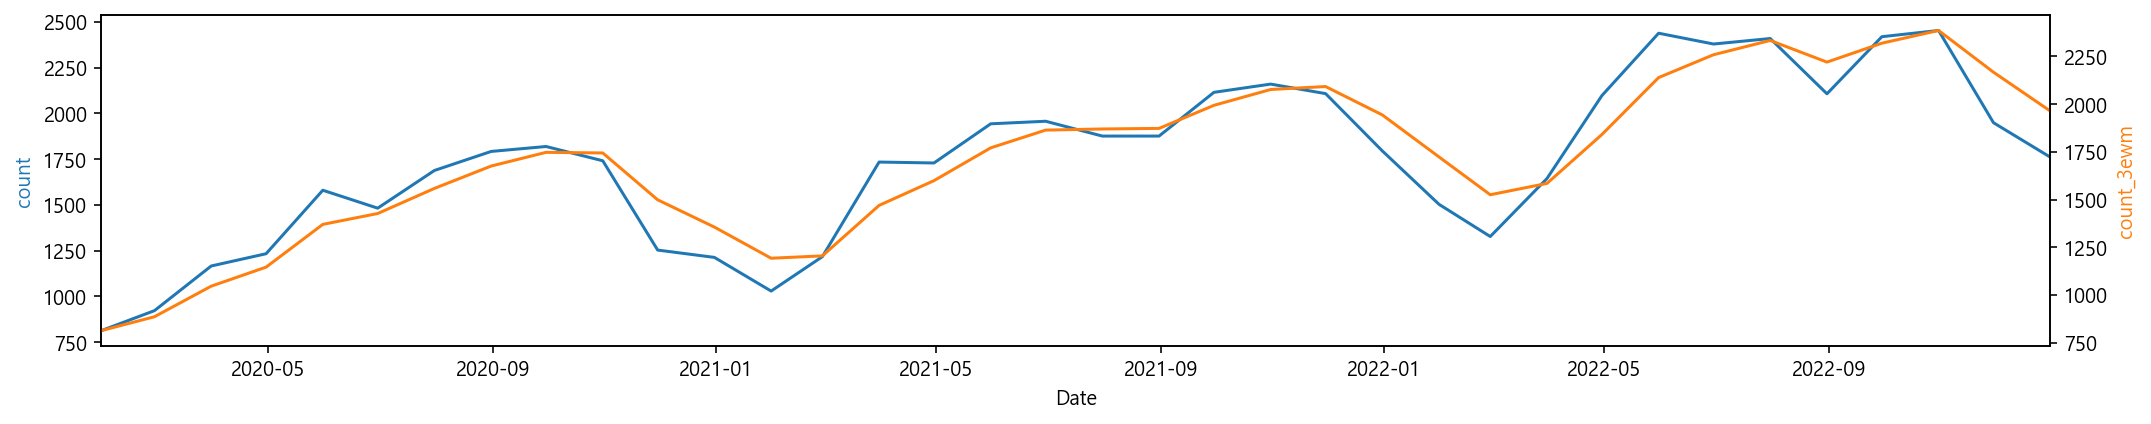

In [175]:
# 예측 결과 시각화
plot_model_graph(ewm_month, 'Date', ['count', 'count_3ewm'])

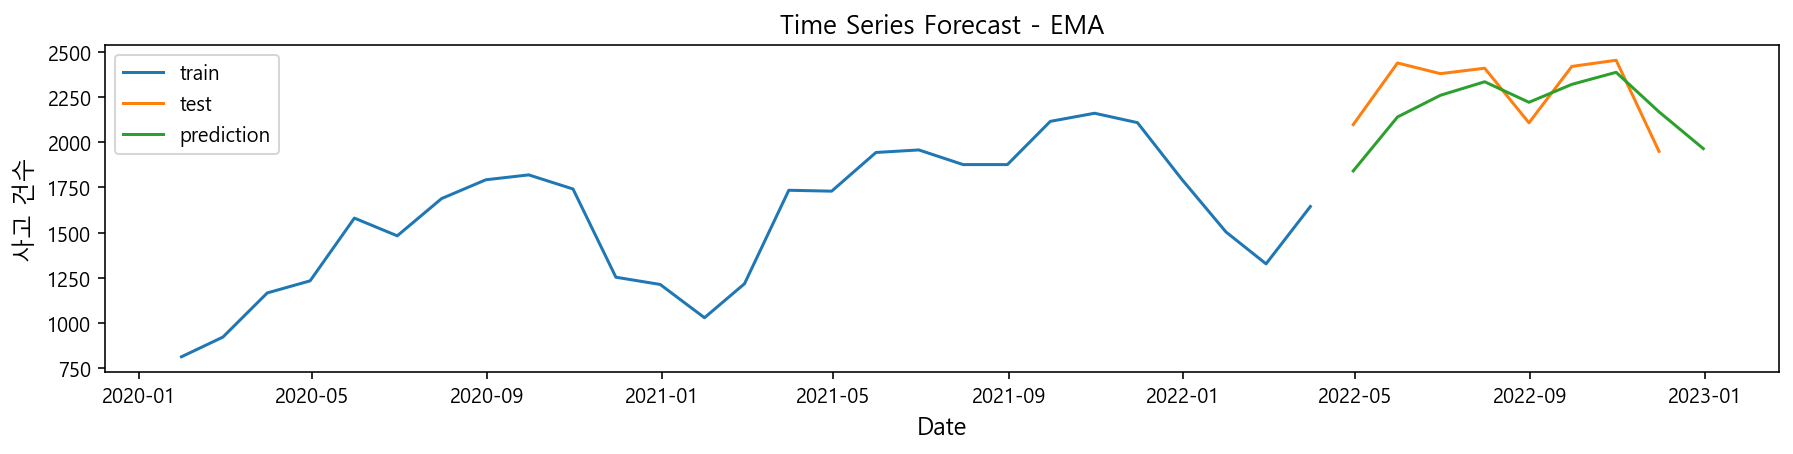

In [176]:
train = ewm_month.iloc[:27]
test = ewm_month.iloc[27:35]
predict = ewm_month.iloc[27:-1]

plot_train_test_pred_graph(train, test, predict)

In [177]:
print("지수이동평균 MAE Score : ", mae(ewm_month.count_3ewm, ewm_month['count'].values))

지수이동평균 MAE Score :  130.4818117261324


In [256]:
pd.DataFrame({
        'MAE':[round( mae(ewm_month.count_3ewm, ewm_month['count'].values), 2)]},
    index = ["EMA의 MAE"])

,MAE
EMA의 MAE,130.48


# 모델링 - Prophet
https://dining-developer.tistory.com/25

In [211]:
test = 음주운전_group.set_index('Date').resample(rule='M').sum()
test = test.reset_index()
test

,Date,count
0,2020-01-31,813
1,2020-02-29,922
2,2020-03-31,1166
3,2020-04-30,1233
4,2020-05-31,1580
5,2020-06-30,1482
6,2020-07-31,1688
7,2020-08-31,1792
8,2020-09-30,1819
9,2020-10-31,1741


## In-Sample Forecast

17:49:22 - cmdstanpy - INFO - Chain [1] start processing
17:49:22 - cmdstanpy - INFO - Chain [1] done processing


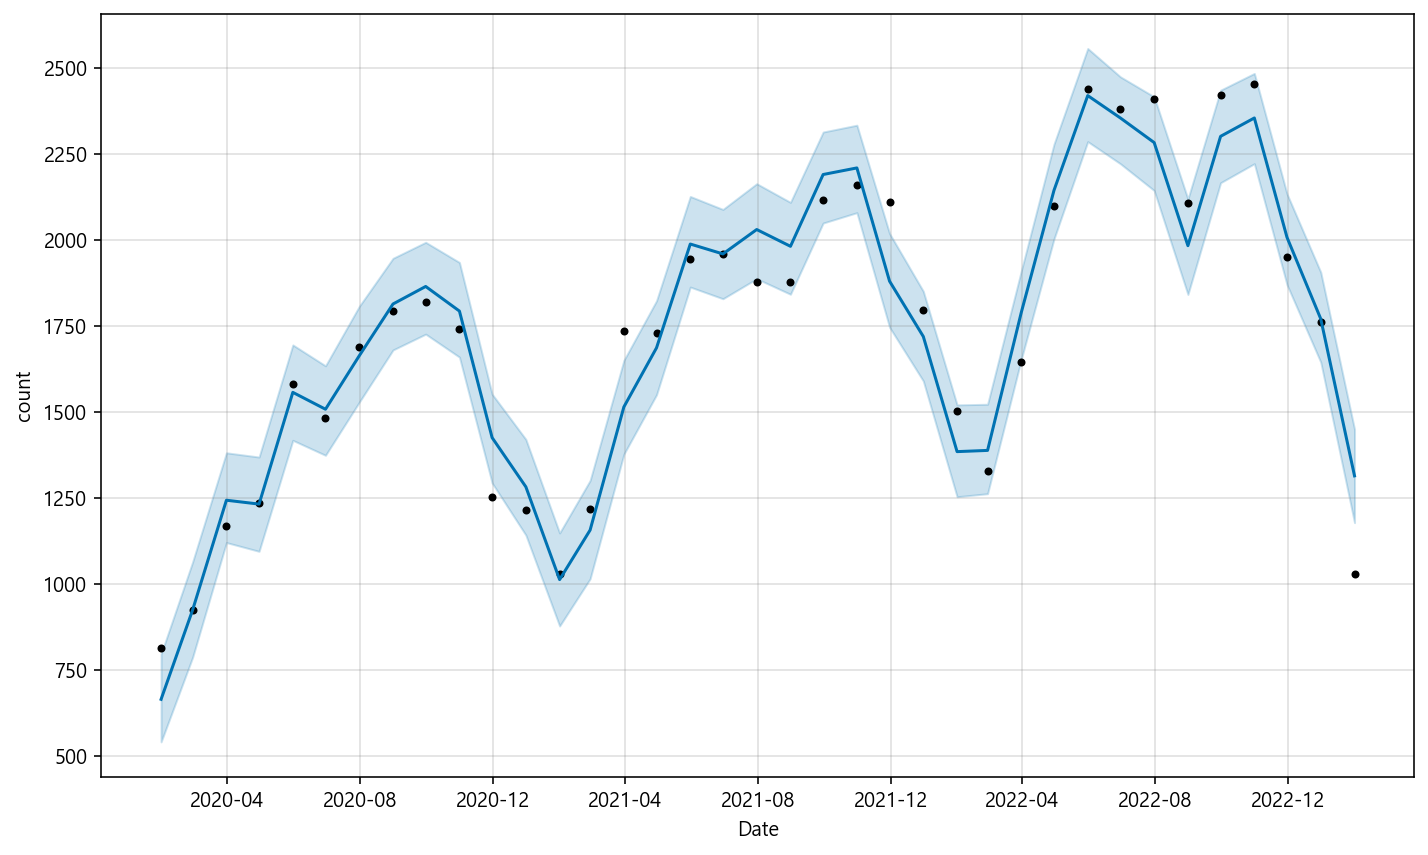

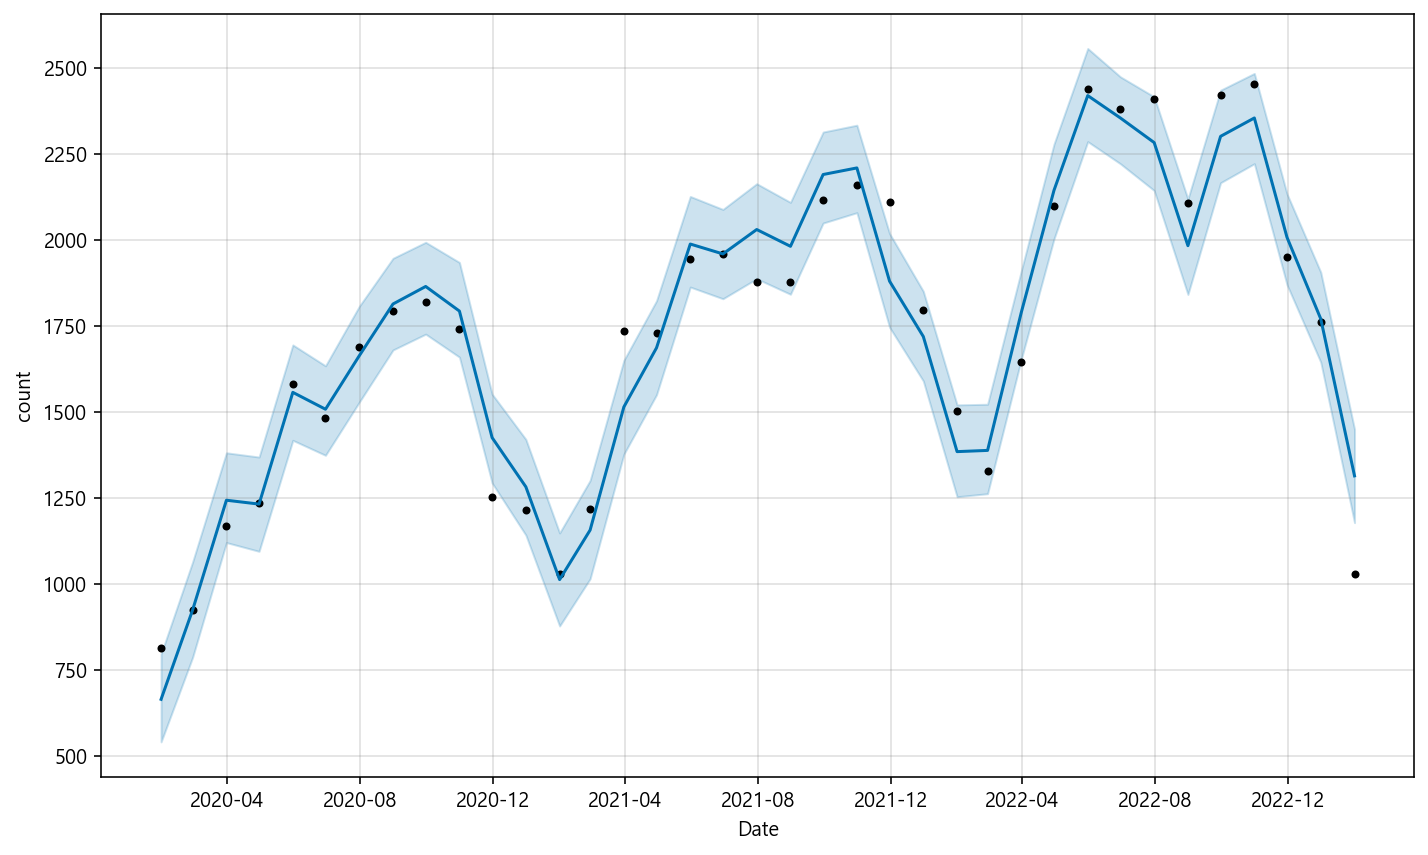

In [61]:
df_prophet = Prophet(changepoint_prior_scale = 0.15, daily_seasonality = True)
df_prophet.fit(test)

df_forecast_predict = df_prophet.predict(df_forecast)
df_forecast_predict[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

df_prophet.plot(df_forecast_predict, xlabel = 'Date', ylabel = 'count')

In [72]:
from sklearn.metrics import mean_absolute_error

test = test.rename(columns = {'Date':'ds', 'count':'y'})

df_forecast = test[['ds']]
df_forecast

train_pro = test
y_true = test['y'].values

model = Prophet()
model.fit(train_pro)

forecast = model.predict(df_forecast)
y_pred = forecast['yhat'].values

prophet_mae = mean_absolute_error(y_true, y_pred)
print(prophet_mae)

17:59:40 - cmdstanpy - INFO - Chain [1] start processing
17:59:40 - cmdstanpy - INFO - Chain [1] done processing


104.08894276024698


In [200]:
df_forecast

,ds
0,2020-01-31
1,2020-02-29
2,2020-03-31
3,2020-04-30
4,2020-05-31
5,2020-06-30
6,2020-07-31
7,2020-08-31
8,2020-09-30
9,2020-10-31


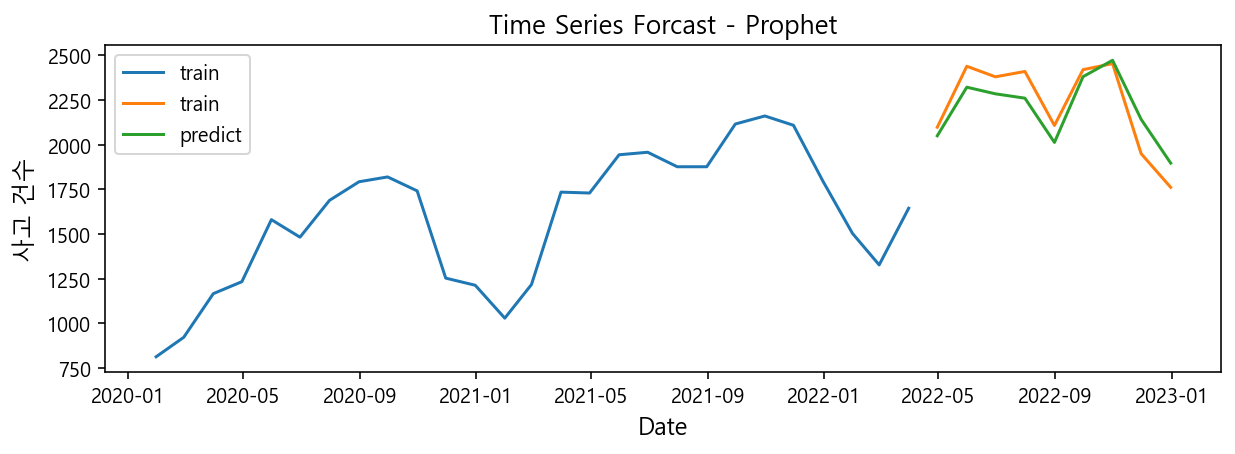

In [71]:
import matplotlib.pyplot as plt

# train
train_plt = test.iloc[:27]

# test
test_plt = test.iloc[27:-1]


# predict
predict_plt_date = test.iloc[27:-1][['ds']]
predict_plt_date['y'] = predict_plt

plt.figure(figsize = (10, 3))
plt.plot(train_plt.ds, train_plt['y'] ,label='train')
plt.plot(test_plt.ds, test_plt['y'] ,label='train')
plt.plot(predict_plt_date.ds, predict_plt_date['y'], label = 'predict')
# plt.plot(test, label = 't,edict')

plt.title('Time Series Forcast - Prophet', fontsize = 13)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('사고 건수', fontsize = 12)
plt.legend()
plt.show()

In [248]:
pd.DataFrame({
        'MAE':[round(prophet_mae, 2)]},
    index = ["Prophet의 MAE"])

,MAE
Prophet의 MAE,104.09


In [250]:
df = pd.DataFrame({
        'MAE':[round(mae(ewm_month.count_3ewm, ewm_month['count'].values), 2), round(scoring(np.array(test1[test1.Date >= start_index]['count'])[:-1], np.array(forecast)),2), round(prophet_mae, 2)]},
    index = ["EMA의 MAE", "ARIMA의 MAE", "Prophet의 MAE"])

In [251]:
df

,MAE
EMA의 MAE,130.48
ARIMA의 MAE,183.87
Prophet의 MAE,104.09


## Prophet으로 미래 예측

In [ ]:
predict_new = pd.DataFrame(pd.date_range(start="2023-01",end="2023-12-31"), columns = ['Date'])
predict_new['count'] = 1
predict_new=predict_new.set_index('Date').resample(rule='M').sum().reset_index()[["Date"]]
predict_new = predict_new.rename(columns = {'Date':'ds'})

In [218]:
A = train_pro.iloc[12:24]

In [221]:
# from sklearn.metrics import mean_absolute_error

test = test.rename(columns = {'Date':'ds', 'count':'y'})

df_forecast = test[['ds']]
df_forecast

train_pro = test
y_true = test['y'].values

model = Prophet()
model.fit(train_pro)

forecast_new = model.predict(predict_new)
y_pred_new = forecast_new['yhat'].values

# prophet_mae_new = mean_absolute_error(y_true, y_pred_new)
# print(prophet_mae_new)

22:09:30 - cmdstanpy - INFO - Chain [1] start processing
22:09:30 - cmdstanpy - INFO - Chain [1] done processing


In [223]:
predict_new

,ds
0,2023-01-31
1,2023-02-28
2,2023-03-31
3,2023-04-30
4,2023-05-31
5,2023-06-30
6,2023-07-31
7,2023-08-31
8,2023-09-30
9,2023-10-31


Text(0, 0.5, '신고 건수')

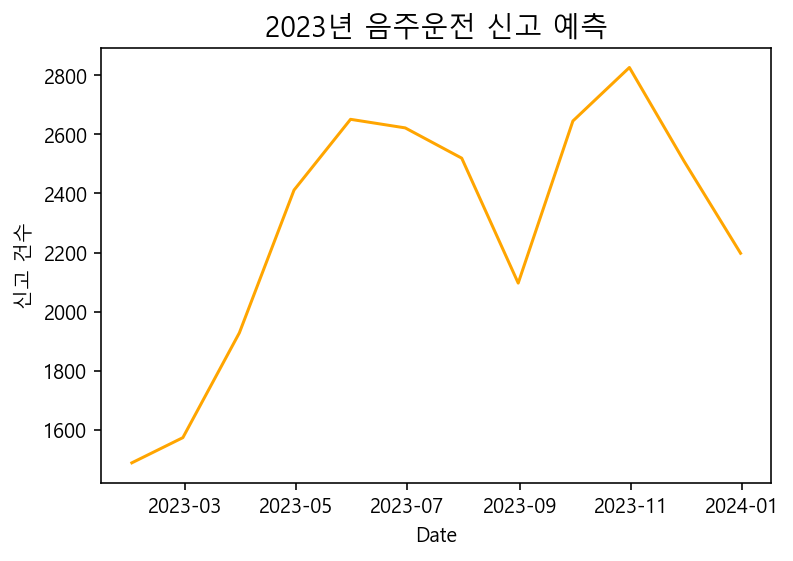

In [245]:
predict_new['y'] = y_pred_new
plt.plot(predict_new.ds, predict_new['y'], color = "orange", label = 'predict')
plt.title("2023년 음주운전 신고 예측", fontsize = 14)
plt.xlabel("Date")
plt.ylabel("신고 건수")
# plt.xlim(['2023-12'])

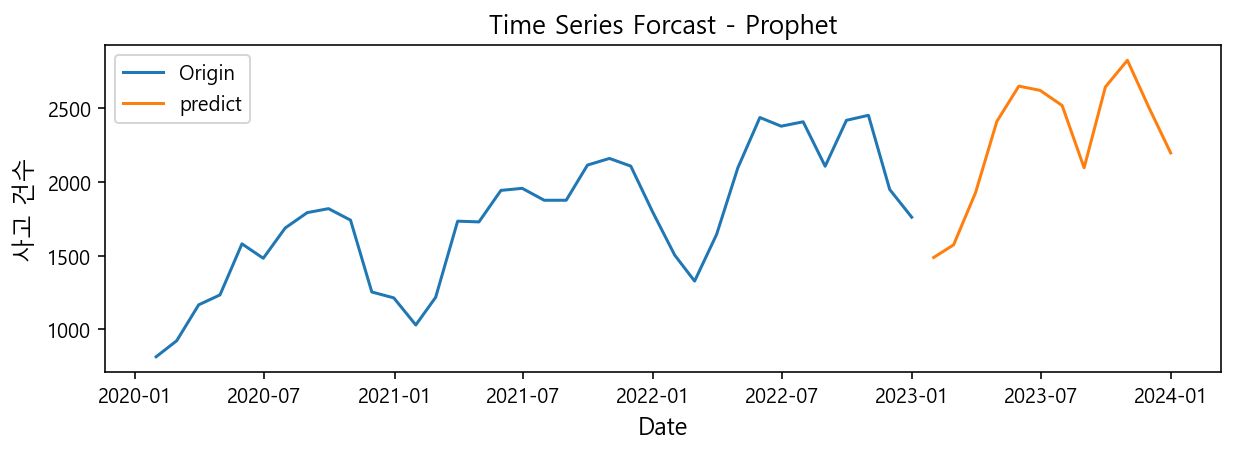

In [229]:
plt.figure(figsize = (10, 3))
plt.plot(test.iloc[:-1].ds, test.iloc[:-1]['y'] ,label='Origin')
plt.plot(predict_new.ds, predict_new['y'], label = 'predict')
# plt.plot(test_plt.ds, test_plt['y'] ,label='train')
# plt.plot(predict_plt_date.ds, predict_plt_date['y'], label = 'predict')
# plt.plot(test, label = 't,edict')

plt.title('Time Series Forcast - Prophet', fontsize = 13)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('사고 건수', fontsize = 12)
plt.legend()
plt.show()

In [261]:
test.iloc[24:36]

,ds,y
24,2022-01-31,1503
25,2022-02-28,1327
26,2022-03-31,1644
27,2022-04-30,2097
28,2022-05-31,2438
29,2022-06-30,2379
30,2022-07-31,2409
31,2022-08-31,2107
32,2022-09-30,2419
33,2022-10-31,2453


In [259]:
def round_0(y):
    return round(y,0)

predict_new['y'] = predict_new['y'].map(round_0)
predict_new

,ds,y
0,2023-01-31,1488.0
1,2023-02-28,1573.0
2,2023-03-31,1928.0
3,2023-04-30,2412.0
4,2023-05-31,2651.0
5,2023-06-30,2622.0
6,2023-07-31,2520.0
7,2023-08-31,2096.0
8,2023-09-30,2646.0
9,2023-10-31,2827.0


In [17]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dropout,Dense
from sklearn.preprocessing import MinMaxScaler

In [18]:
df_month_dl = 음주운전.groupby('Date')[['count']].sum()

normalized_arr = np.array([])

df_set = df_month_dl['count'].values
set_arr = np.array([(float(i + 1) / float(df_set[0] + 1))-1 for i in df_set])
normalized_arr = np.concatenate((normalized_arr, set_arr))

df_month_dl.insert(1, 'normalize', normalized_arr)

In [19]:
df_month_dl

,count,normalize
Date,,
2020-01-01,25,0.000000
2020-01-02,21,-0.153846
2020-01-03,26,0.038462
2020-01-04,30,0.192308
2020-01-05,30,0.192308
...,...,...
2023-01-14,68,1.653846
2023-01-15,46,0.807692
2023-01-16,46,0.807692


### ---

In [78]:
!pip install torch

In [79]:
import numpy as np
import pandas as pd
import pandas_datareader.data as pdr
import matplotlib.pyplot as plt

import datetime

import torch
import torch.nn as nn
from torch.autograd import Variable 

import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

### ---

In [88]:
dl_x = df_month_dl.index.values
dl_y = df_month_dl.normalize

size = int(len(df_month_dl) * 0.7)
x_train = dl_x[:size]
y_train = dl_y[:size]
x_test = dl_x[size:]
y_test = dl_y[size:]

x_train = x_train.reshape(x_train.shape[0], 1)
x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))


x_test = x_test.reshape(len(x_test), 1)
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))

y_train = y_train.reshape(len(y_train), 1)
# y_train = np.reshape(y_train, (y_train.shape[0], 1, y_train.shape[1]))


# y_test = y_test.reshape(len(y_test), 1)
# y_test = np.reshape(y_test, (y_test.shape[0], 1, y_test.shape[1]))


AttributeError: 'Series' object has no attribute 'reshape'

In [46]:
# 모델 생성
model = Sequential()

model.add(LSTM
          (units=50,
           input_shape=(len(dl_x), 1),
           return_sequences=True))
model.add(Dropout(0.2))        # overfitting을 방지하기 위한 Dropout 설정(20%)

model.add(LSTM(100,
              return_sequences=False)) # Dense layer에 들어가기 전이므로 False
model.add(Dropout(0.2))

model.add(Dense(1, activation='relu'))

# normalize로 value가 작아졌기 때문에 mse로 진행
model.compile(loss='mean_squared_error', optimizer='adam')

In [47]:
# 모델 학습,  validation_split=0.05
model.fit(x_train, y_train, epochs=100, verbose=0)

ValueError: in user code:

    File "C:\Users\jemin\anaconda3\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\jemin\anaconda3\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\jemin\anaconda3\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\jemin\anaconda3\lib\site-packages\keras\engine\training.py", line 993, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\jemin\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\jemin\anaconda3\lib\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_6" is incompatible with the layer: expected shape=(None, 1105, 1), found shape=(None, 1, 1)


In [37]:
y_train

Date
2020-01-01    0.000000
2020-01-02   -0.153846
2020-01-03    0.038462
2020-01-04    0.192308
2020-01-05    0.192308
                ...   
2022-02-15    1.230769
2022-02-16    1.115385
2022-02-17    0.692308
2022-02-18    0.423077
2022-02-19    1.423077
Name: normalize, Length: 773, dtype: float64

In [38]:
final_dataset = df_month_dl['normalize'].values

x_train_data = final_dataset[:size]
y_train_data = final_dataset[size:]

In [39]:
x_train_data=np.reshape(x_train_data,(x_train_data.shape[0],1))
y_train_data=np.reshape(y_train_data,(y_train_data.shape[0],1))

In [43]:
lstm_model=Sequential()
lstm_model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train_data.shape[1],1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))

# inputs_data=new_dataset[len(new_dataset)-len(valid_data)-60:].values
# inputs_data=inputs_data.reshape(-1,1)
# inputs_data=scaler.transform(inputs_data)

lstm_model.compile(loss='mean_squared_error',optimizer='adam')
lstm_model.fit(x_train,y_train,epochs=1,batch_size=1,verbose=2)
 

UnimplementedError: Graph execution error:

Detected at node 'sequential_5/Cast' defined at (most recent call last):
    File "C:\Users\jemin\anaconda3\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\jemin\anaconda3\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\jemin\anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "C:\Users\jemin\anaconda3\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "C:\Users\jemin\anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 677, in start
      self.io_loop.start()
    File "C:\Users\jemin\anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\jemin\anaconda3\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "C:\Users\jemin\anaconda3\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "C:\Users\jemin\anaconda3\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\jemin\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 471, in dispatch_queue
      await self.process_one()
    File "C:\Users\jemin\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 460, in process_one
      await dispatch(*args)
    File "C:\Users\jemin\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 367, in dispatch_shell
      await result
    File "C:\Users\jemin\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 662, in execute_request
      reply_content = await reply_content
    File "C:\Users\jemin\anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 360, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "C:\Users\jemin\anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 532, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\jemin\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2863, in run_cell
      result = self._run_cell(
    File "C:\Users\jemin\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2909, in _run_cell
      return runner(coro)
    File "C:\Users\jemin\anaconda3\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\jemin\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3106, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\jemin\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3309, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\jemin\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3369, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\jemin\AppData\Local\Temp\ipykernel_35148\657852207.py", line 11, in <cell line: 11>
      lstm_model.fit(x_train,y_train,epochs=1,batch_size=1,verbose=2)
    File "C:\Users\jemin\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\jemin\anaconda3\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\jemin\anaconda3\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "C:\Users\jemin\anaconda3\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\jemin\anaconda3\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "C:\Users\jemin\anaconda3\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "C:\Users\jemin\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\jemin\anaconda3\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\jemin\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\jemin\anaconda3\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\jemin\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\jemin\anaconda3\lib\site-packages\keras\engine\sequential.py", line 410, in call
      return super().call(inputs, training=training, mask=mask)
    File "C:\Users\jemin\anaconda3\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "C:\Users\jemin\anaconda3\lib\site-packages\keras\engine\functional.py", line 649, in _run_internal_graph
      y = self._conform_to_reference_input(y, ref_input=x)
    File "C:\Users\jemin\anaconda3\lib\site-packages\keras\engine\functional.py", line 761, in _conform_to_reference_input
      tensor = tf.cast(tensor, dtype=ref_input.dtype)
Node: 'sequential_5/Cast'
Cast string to float is not supported
	 [[{{node sequential_5/Cast}}]] [Op:__inference_train_function_23364]

In [42]:
x_train_data

array([[ 0.        ],
       [-0.15384615],
       [ 0.03846154],
       [ 0.19230769],
       [ 0.19230769],
       [-0.5       ],
       [-0.23076923],
       [-0.15384615],
       [-0.07692308],
       [-0.11538462],
       [ 0.26923077],
       [ 0.03846154],
       [-0.30769231],
       [ 0.57692308],
       [ 0.46153846],
       [-0.11538462],
       [ 0.19230769],
       [ 0.38461538],
       [-0.15384615],
       [ 0.11538462],
       [-0.19230769],
       [-0.03846154],
       [ 0.11538462],
       [ 0.23076923],
       [ 0.61538462],
       [ 0.38461538],
       [ 0.23076923],
       [-0.15384615],
       [-0.11538462],
       [-0.19230769],
       [-0.07692308],
       [-0.15384615],
       [ 0.19230769],
       [-0.34615385],
       [-0.26923077],
       [-0.11538462],
       [-0.15384615],
       [ 0.38461538],
       [ 0.5       ],
       [ 0.76923077],
       [ 0.03846154],
       [ 0.26923077],
       [ 0.15384615],
       [ 0.65384615],
       [ 0.65384615],
       [ 0